## Modelo datos estructurados
Este notebook desarrolla un primer modelo para resolver el problema de Petfinder. Empezamos haciendo un modelo inicial muy simple para ver la viabilidad de resolver el problema. Luego analizamos como se comporta la métrica kappa propuesta y vemos la matriz de confusión. Finalmente hacemos una optimizacin de hiperparametros evaluando con train/test y otra validando con 5 fold CV y testeando en el 20% de los datos

In [24]:
#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score,classification_report #Metricas
from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump


In [7]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la carpeta donde se ejecuta el notebook). 
# /input
# /input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_LDI_II/
# /UA_MDM_LDI_II/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_LDI_II/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_LDI_II/work//models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_LDI_II/work//optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_LDI_II/work//optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_LDI_II
BASE_DIR = './'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "data/train/train_sentimentFE_final.csv")
#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 55 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
BATCH_SIZE= 50
TEST_SIZE = 0.2 #Facción para train/test= split

In [8]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN)

In [9]:
#Columnas del dataset
dataset.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt', 'AdoptionSpeed', 'BreedID', 'BreedName',
       'BreedID_SecondaryBreed', 'BreedName_SecondaryBreed', 'Age_target',
       'doc_sentiment_score_MEAN', 'doc_sentiment_score_SUM',
       'doc_sentiment_magnitude_MEAN', 'doc_sentiment_magnitude_SUM',
       'sentence_sentiment_score_MEAN', 'sentence_sentiment_score_SUM',
       'sentence_sentiment_magnitude_MEAN', 'sentence_sentiment_magnitude_SUM',
       'SVD_Description_0', 'SVD_Description_1', 'SVD_Description_2',
       'SVD_Description_3', 'SVD_Description_4', 'NMF_Description_0',
       'NMF_Description_1', 'NMF_Description_2', 'NMF_Description_3',
       'NMF_Description_4', 'SVD_entity_name_0', 'SVD_entity_name_1',
       'SVD_entity_name_2', 'SVD_entity_name_3', 'SVD_entity_name_4',
       'NMF_enti

In [10]:
#Separo un 20% para test estratificado opr target
train, test = train_test_split(dataset,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = dataset.Age_target)

In [11]:
#Armo listas con features de texto y numericas
char_feats = [f for f in dataset.columns if dataset[f].dtype=='O']
numeric_feats = [f for f in dataset.columns if dataset[f].dtype!='O']

In [12]:

#Defino features a usar en un primer modelo de prueba
features = ['Type','Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt', 'AdoptionSpeed', 'BreedName',
       'BreedName_SecondaryBreed',
       'doc_sentiment_score_MEAN', 'doc_sentiment_score_SUM',
       'doc_sentiment_magnitude_MEAN', 'doc_sentiment_magnitude_SUM',
       'sentence_sentiment_score_MEAN', 'sentence_sentiment_score_SUM',
       'sentence_sentiment_magnitude_MEAN', 'sentence_sentiment_magnitude_SUM',
       'SVD_Description_0', 'SVD_Description_1', 'SVD_Description_2',
       'SVD_Description_3', 'SVD_Description_4', 'NMF_Description_0',
       'NMF_Description_1', 'NMF_Description_2', 'NMF_Description_3',
       'NMF_Description_4', 'SVD_entity_name_0', 'SVD_entity_name_1',
       'SVD_entity_name_2', 'SVD_entity_name_3', 'SVD_entity_name_4',
       'NMF_entity_name_0', 'NMF_entity_name_1', 'NMF_entity_name_2',
       'NMF_entity_name_3', 'NMF_entity_name_4']

label = 'Age_target'

In [13]:
#Genero dataframes de train y test con sus respectivos targets
X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]

In [14]:
#Entreno un modelo inicial sin modificar hiperparametros. Solamente especifico el numero de clases y el tipo de modelo como clasificacoión
lgb_params = params = {
                        'force_row_wise': True,
                        'objective': 'multiclass',
                        'num_class': len(y_train.unique())
                        }


#genero el objeto Dataset que debo pasarle a lightgbm para que entrene
lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)

#entreno el modelo con los parametros por defecto
lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Total Bins 6869
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 49
[LightGBM] [Info] Start training from score -0.634221
[LightGBM] [Info] Start training from score -1.891080
[LightGBM] [Info] Start training from score -2.015654
[LightGBM] [Info] Start training from score -2.491431
[LightGBM] [Info] Start training from score -3.247976
[LightGBM] [Info] Start training from score -3.073194
[LightGBM] [Info] Start training from score -4.083894
[LightGBM] [Info] Start training from score -7.194937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [16]:
#Obtengo las predicciones sobre el set de test. El modelo me da una lista de probabilidades para cada clase y tomo la clase con mayor probabilidad con la funcion argmax
y_pred = lgb_model.predict(X_test).argmax(axis=1)

#Calculo el Kappa

print("Cohen Kappa Score Escenario inicial:",cohen_kappa_score(y_test,y_pred, weights = 'quadratic'))

Cohen Kappa Score Escenario inicial: 0.6678061385227508


In [17]:
#Muestro la matriz de confusión
display(plot_confusion_matrix(y_test,y_pred))

In [18]:
#Pruebo un modelo alternativo donde en vez de usar la version multiclass real de lightGBM utilizo One vs All

lgb_params = params = {
                        'force_row_wise': True,
                        'objective': 'multiclassova',
                        'num_class': len(y_train.unique())
                        }


lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


lgb_model = lgb.train(lgb_params,
                      lgb_train_dataset)

[LightGBM] [Info] Number of positive: 6361, number of negative: 5633
[LightGBM] [Info] Number of positive: 1810, number of negative: 10184
[LightGBM] [Info] Number of positive: 1598, number of negative: 10396
[LightGBM] [Info] Number of positive: 993, number of negative: 11001
[LightGBM] [Info] Number of positive: 466, number of negative: 11528
[LightGBM] [Info] Number of positive: 555, number of negative: 11439
[LightGBM] [Info] Number of positive: 202, number of negative: 11792
[LightGBM] [Info] Number of positive: 9, number of negative: 11985
[LightGBM] [Info] Total Bins 6869
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530349 -> initscore=0.121543
[LightGBM] [Info] Start training from score 0.121543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150909 -> initscore=-1.727491
[LightGBM] [Info] Start training from score -1.727491
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.13323

In [19]:
#MAtriz de confusion y Kappa dfe OVA
y_pred = lgb_model.predict(X_test).argmax(axis=1)

display(plot_confusion_matrix(y_test,y_pred))

{'kappa':cohen_kappa_score(y_test,
                y_pred,
                weights = 'quadratic'),
 'accuracy':accuracy_score(y_test,y_pred),
 'balanced_accuracy':balanced_accuracy_score(y_test,y_pred)}




{'kappa': np.float64(0.6521981223834135),
 'accuracy': 0.6142047349116372,
 'balanced_accuracy': np.float64(0.3174938173914039)}

## Modelo con cross validation y conjunto de test

In [20]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.95),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),  # Nuevo hiperparámetro
                        'max_depth': trial.suggest_int('max_depth', -1, 20)  # Nuevo hiperparámetro
                        
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits

    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    
    print(artifact_store)
    
    
    #Aca puedo tener error cualquier cosa comentar el codigo
    #Grabo natriz de confusion
    #Nombre de archivo
    # cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    # #Grabo archivo
    # plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    # #Asocio al trial
    # upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [106]:
# import kaleido
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="01-LGB Multiclass CV 2110-14hs",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_lgb_objective, n_trials=250)

[I 2024-10-21 14:18:17,083] A new study created in RDB with name: 01-LGB Multiclass CV 2110-14hs
/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:18:53,085] Trial 0 finished with value: 0.625147683693114 and parameters: {'lambda_l1': 2.1622404855379867e-06, 'lambda_l2': 0.010921550240558813, 'num_leaves': 119, 'feature_fraction': 0.4506097817410098, 'bagging_fraction': 0.3560496608329399, 'bagging_freq': 5, 'min_child_samples': 95, 'min_split_gain': 0.06289603356334439, 'max_depth': 8}. Best is trial 0 with value: 0.625147683693114.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:19:15,850] Trial 1 finished with value: 0.6238806635612911 and parameters: {'lambda_l1': 0.004591143850600864, 'lambda_l2': 5.560998245180279e-07, 'num_leaves': 204, 'feature_fraction': 0.7411711541740409, 'bagging_fraction': 0.3606551294235879, 'bagging_freq': 4, 'min_child_samples': 88, 'min_split_gain': 0.3132511385861255, 'max_depth': 15}. Best is trial 0 with value: 0.625147683693114.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:20:10,441] Trial 2 finished with value: 0.6158733637979332 and parameters: {'lambda_l1': 4.210738426861107, 'lambda_l2': 3.309407137328379e-05, 'num_leaves': 216, 'feature_fraction': 0.5995624340522836, 'bagging_fraction': 0.24487885823754343, 'bagging_freq': 1, 'min_child_samples': 29, 'min_split_gain': 0.2501064443280868, 'max_depth': 15}. Best is trial 0 with value: 0.625147683693114.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:21:26,681] Trial 3 finished with value: 0.6317382816929449 and parameters: {'lambda_l1': 0.001490692135065489, 'lambda_l2': 2.2470439233868776e-05, 'num_leaves': 98, 'feature_fraction': 0.8575988277972393, 'bagging_fraction': 0.7887465157255049, 'bagging_freq': 4, 'min_child_samples': 18, 'min_split_gain': 0.287565897612905, 'max_depth': 3}. Best is trial 3 with value: 0.6317382816929449.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:23:00,393] Trial 4 finished with value: 0.6263484067123793 and parameters: {'lambda_l1': 1.9558178966861374e-06, 'lambda_l2': 3.076286380913614, 'num_leaves': 232, 'feature_fraction': 0.6579241129039746, 'bagging_fraction': 0.44115757154460045, 'bagging_freq': 1, 'min_child_samples': 56, 'min_split_gain': 0.4000813756046258, 'max_depth': -1}. Best is trial 3 with value: 0.6317382816929449.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:23:07,583] Trial 5 finished with value: 0.0 and parameters: {'lambda_l1': 1.2273802937860011e-06, 'lambda_l2': 1.3803480724417913e-07, 'num_leaves': 190, 'feature_fraction': 0.285703854107629, 'bagging_fraction': 0.5157213388248318, 'bagging_freq': 6, 'min_child_samples': 29, 'min_split_gain': 0.31661424833055224, 'max_depth': 1}. Best is trial 3 with value: 0.6317382816929449.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:24:04,899] Trial 6 finished with value: 0.6378395222444454 and parameters: {'lambda_l1': 0.9338852248049585, 'lambda_l2': 1.8786803336132737e-06, 'num_leaves': 21, 'feature_fraction': 0.7495476059060266, 'bagging_fraction': 0.3975519161359292, 'bagging_freq': 6, 'min_child_samples': 94, 'min_split_gain': 0.016432805896081593, 'max_depth': 10}. Best is trial 6 with value: 0.6378395222444454.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:24:41,935] Trial 7 finished with value: 0.6360170713968681 and parameters: {'lambda_l1': 0.6405508968794796, 'lambda_l2': 4.977783010232343e-06, 'num_leaves': 141, 'feature_fraction': 0.8690793377603929, 'bagging_fraction': 0.4595554508329762, 'bagging_freq': 3, 'min_child_samples': 76, 'min_split_gain': 0.30483585563487875, 'max_depth': 13}. Best is trial 6 with value: 0.6378395222444454.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:25:17,811] Trial 8 finished with value: 0.6499166442420301 and parameters: {'lambda_l1': 0.7351953456101958, 'lambda_l2': 1.9586969960649116e-06, 'num_leaves': 229, 'feature_fraction': 0.9381219729604295, 'bagging_fraction': 0.8952679182562406, 'bagging_freq': 3, 'min_child_samples': 80, 'min_split_gain': 0.2564569985786936, 'max_depth': 13}. Best is trial 8 with value: 0.6499166442420301.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:25:54,334] Trial 9 finished with value: 0.6431034904710784 and parameters: {'lambda_l1': 9.00900401852593e-08, 'lambda_l2': 0.4542437566973649, 'num_leaves': 251, 'feature_fraction': 0.90840363244612, 'bagging_fraction': 0.848242203668911, 'bagging_freq': 7, 'min_child_samples': 75, 'min_split_gain': 0.4730196121968178, 'max_depth': 10}. Best is trial 8 with value: 0.6499166442420301.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:26:27,156] Trial 10 finished with value: 0.6347928607677111 and parameters: {'lambda_l1': 0.03073124355945114, 'lambda_l2': 0.0018691488260800901, 'num_leaves': 165, 'feature_fraction': 0.45655658421061374, 'bagging_fraction': 0.679373350944158, 'bagging_freq': 2, 'min_child_samples': 53, 'min_split_gain': 0.14156901447868062, 'max_depth': 20}. Best is trial 8 with value: 0.6499166442420301.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:27:07,678] Trial 11 finished with value: 0.6555539366233969 and parameters: {'lambda_l1': 2.959551001384166e-08, 'lambda_l2': 6.6791733110880305, 'num_leaves': 235, 'feature_fraction': 0.9286109640355875, 'bagging_fraction': 0.9461752551763629, 'bagging_freq': 7, 'min_child_samples': 70, 'min_split_gain': 0.49930660341365435, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:27:38,551] Trial 12 finished with value: 0.6492318945534189 and parameters: {'lambda_l1': 1.0397801111149674e-08, 'lambda_l2': 1.5700064251975615e-08, 'num_leaves': 72, 'feature_fraction': 0.9443538499180802, 'bagging_fraction': 0.9475055830477177, 'bagging_freq': 3, 'min_child_samples': 68, 'min_split_gain': 0.486631947565389, 'max_depth': 6}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:28:08,355] Trial 13 finished with value: 0.6485496811598115 and parameters: {'lambda_l1': 3.748855569781593e-05, 'lambda_l2': 0.05426146783423217, 'num_leaves': 252, 'feature_fraction': 0.7792159651173851, 'bagging_fraction': 0.9413509623697754, 'bagging_freq': 7, 'min_child_samples': 65, 'min_split_gain': 0.16597406684692362, 'max_depth': 5}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:28:45,368] Trial 14 finished with value: 0.6250324808258753 and parameters: {'lambda_l1': 0.00018901582582025886, 'lambda_l2': 0.00044044387024357344, 'num_leaves': 173, 'feature_fraction': 0.8117270294143646, 'bagging_fraction': 0.679528616087762, 'bagging_freq': 3, 'min_child_samples': 39, 'min_split_gain': 0.3906892738313592, 'max_depth': 20}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:29:20,967] Trial 15 finished with value: 0.646522391673827 and parameters: {'lambda_l1': 0.09584205396146958, 'lambda_l2': 5.172741877265453, 'num_leaves': 220, 'feature_fraction': 0.94070998296306, 'bagging_fraction': 0.8129927718772982, 'bagging_freq': 5, 'min_child_samples': 83, 'min_split_gain': 0.17979648835712275, 'max_depth': 13}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:29:48,695] Trial 16 finished with value: 0.6406200996280986 and parameters: {'lambda_l1': 3.634582718059712e-05, 'lambda_l2': 9.391076711189451e-05, 'num_leaves': 154, 'feature_fraction': 0.6761931672278254, 'bagging_fraction': 0.6637368401711419, 'bagging_freq': 2, 'min_child_samples': 100, 'min_split_gain': 0.39144623820474195, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:30:23,317] Trial 17 finished with value: 0.5971714799110063 and parameters: {'lambda_l1': 0.02429130926645269, 'lambda_l2': 0.1364341462188214, 'num_leaves': 186, 'feature_fraction': 0.20318036567792996, 'bagging_fraction': 0.8773081201487481, 'bagging_freq': 4, 'min_child_samples': 43, 'min_split_gain': 0.10051761728952469, 'max_depth': 12}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:30:55,886] Trial 18 finished with value: 0.6454818415985414 and parameters: {'lambda_l1': 1.0829061600423687e-07, 'lambda_l2': 1.0109233091686007e-08, 'num_leaves': 10, 'feature_fraction': 0.5023955860056334, 'bagging_fraction': 0.7479061689250828, 'bagging_freq': 5, 'min_child_samples': 62, 'min_split_gain': 0.2208493925629466, 'max_depth': 16}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:31:25,180] Trial 19 finished with value: 0.6376369063900988 and parameters: {'lambda_l1': 7.5817929194803755, 'lambda_l2': 0.0020263955449044196, 'num_leaves': 60, 'feature_fraction': 0.8342741623162013, 'bagging_fraction': 0.6085098931252078, 'bagging_freq': 6, 'min_child_samples': 78, 'min_split_gain': 0.4244810508774848, 'max_depth': 17}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:31:54,236] Trial 20 finished with value: 0.6144805024651354 and parameters: {'lambda_l1': 0.00053354825131926, 'lambda_l2': 3.4832858080554737e-07, 'num_leaves': 256, 'feature_fraction': 0.6590675774117981, 'bagging_fraction': 0.881541315265969, 'bagging_freq': 2, 'min_child_samples': 8, 'min_split_gain': 0.4357843151426365, 'max_depth': 4}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:32:21,707] Trial 21 finished with value: 0.6447093847078285 and parameters: {'lambda_l1': 1.2839129642527051e-08, 'lambda_l2': 1.665646740977791e-08, 'num_leaves': 90, 'feature_fraction': 0.9284374189717873, 'bagging_fraction': 0.9497179845613041, 'bagging_freq': 3, 'min_child_samples': 68, 'min_split_gain': 0.4986213323800612, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:32:55,248] Trial 22 finished with value: 0.6504805823695914 and parameters: {'lambda_l1': 1.358485507673326e-08, 'lambda_l2': 5.8311001387273187e-08, 'num_leaves': 40, 'feature_fraction': 0.8873111973586206, 'bagging_fraction': 0.9425264313951096, 'bagging_freq': 3, 'min_child_samples': 69, 'min_split_gain': 0.3529054686248341, 'max_depth': 6}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:33:29,294] Trial 23 finished with value: 0.6526729603943765 and parameters: {'lambda_l1': 1.2407107513543547e-07, 'lambda_l2': 6.848693865517469e-08, 'num_leaves': 40, 'feature_fraction': 0.8515536582421459, 'bagging_fraction': 0.7752714701609821, 'bagging_freq': 2, 'min_child_samples': 85, 'min_split_gain': 0.240020921618116, 'max_depth': 9}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:34:07,555] Trial 24 finished with value: 0.6071451672799438 and parameters: {'lambda_l1': 1.1646891071112308e-07, 'lambda_l2': 1.129458539544183e-07, 'num_leaves': 49, 'feature_fraction': 0.8555311149078789, 'bagging_fraction': 0.7562412394640378, 'bagging_freq': 2, 'min_child_samples': 87, 'min_split_gain': 0.348355916580989, 'max_depth': 2}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:34:33,431] Trial 25 finished with value: 0.6483354428190575 and parameters: {'lambda_l1': 4.756147415328424e-07, 'lambda_l2': 6.840663575390597e-08, 'num_leaves': 34, 'feature_fraction': 0.7242225053126494, 'bagging_fraction': 0.8196639111186866, 'bagging_freq': 1, 'min_child_samples': 57, 'min_split_gain': 0.2124165719305495, 'max_depth': 9}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:35:06,800] Trial 26 finished with value: 0.46744052733550406 and parameters: {'lambda_l1': 1.3981815705572312e-05, 'lambda_l2': 1.2996142063752496e-05, 'num_leaves': 2, 'feature_fraction': 0.7975394161281728, 'bagging_fraction': 0.7401174082852038, 'bagging_freq': 4, 'min_child_samples': 45, 'min_split_gain': 0.3738195655106267, 'max_depth': 11}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:35:38,739] Trial 27 finished with value: 0.6438680547876539 and parameters: {'lambda_l1': 3.503052522723936e-08, 'lambda_l2': 0.0001431373728518165, 'num_leaves': 122, 'feature_fraction': 0.8892687548367935, 'bagging_fraction': 0.9034287891943636, 'bagging_freq': 2, 'min_child_samples': 72, 'min_split_gain': 0.4422655201494284, 'max_depth': 6}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:36:05,218] Trial 28 finished with value: 0.6315054561973994 and parameters: {'lambda_l1': 3.482881837672329e-07, 'lambda_l2': 7.856220348153235e-07, 'num_leaves': 37, 'feature_fraction': 0.5492487628536274, 'bagging_fraction': 0.5885855590418023, 'bagging_freq': 7, 'min_child_samples': 62, 'min_split_gain': 0.352928804808599, 'max_depth': 8}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:36:38,192] Trial 29 finished with value: 0.6412637577690965 and parameters: {'lambda_l1': 9.549812048279644e-06, 'lambda_l2': 0.019239852307847364, 'num_leaves': 98, 'feature_fraction': 0.36523370505557173, 'bagging_fraction': 0.8419413631680485, 'bagging_freq': 5, 'min_child_samples': 91, 'min_split_gain': 0.28112308497181693, 'max_depth': 8}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:37:08,596] Trial 30 finished with value: 0.6447075841177548 and parameters: {'lambda_l1': 3.422127581942054e-08, 'lambda_l2': 0.003860533938620419, 'num_leaves': 77, 'feature_fraction': 0.699252955783373, 'bagging_fraction': 0.7830601368016769, 'bagging_freq': 4, 'min_child_samples': 86, 'min_split_gain': 0.10547378584377864, 'max_depth': 4}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:37:47,922] Trial 31 finished with value: 0.6464120865787977 and parameters: {'lambda_l1': 3.65620742008463e-07, 'lambda_l2': 3.4888358249392603e-06, 'num_leaves': 234, 'feature_fraction': 0.898690682879157, 'bagging_fraction': 0.900643153467158, 'bagging_freq': 3, 'min_child_samples': 81, 'min_split_gain': 0.2575195823964429, 'max_depth': 9}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:38:25,157] Trial 32 finished with value: 0.6433173702575169 and parameters: {'lambda_l1': 5.387790394698739e-06, 'lambda_l2': 3.218186682558539e-08, 'num_leaves': 201, 'feature_fraction': 0.8218087315651621, 'bagging_fraction': 0.8882478596035313, 'bagging_freq': 3, 'min_child_samples': 72, 'min_split_gain': 0.21505626341415163, 'max_depth': 12}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:39:02,299] Trial 33 finished with value: 0.6486433785041513 and parameters: {'lambda_l1': 3.274270725799635e-08, 'lambda_l2': 6.652025242060729e-07, 'num_leaves': 113, 'feature_fraction': 0.9475078098809157, 'bagging_fraction': 0.9128345418245237, 'bagging_freq': 2, 'min_child_samples': 97, 'min_split_gain': 0.3317799971324027, 'max_depth': 14}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:39:28,136] Trial 34 finished with value: 0.63398672877413 and parameters: {'lambda_l1': 0.0066692260346234555, 'lambda_l2': 2.2611902563555836e-07, 'num_leaves': 48, 'feature_fraction': 0.7639770274681069, 'bagging_fraction': 0.2589058251169311, 'bagging_freq': 1, 'min_child_samples': 82, 'min_split_gain': 0.2670499673252046, 'max_depth': 11}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:40:02,612] Trial 35 finished with value: 0.6431432864023351 and parameters: {'lambda_l1': 8.737437074899065e-07, 'lambda_l2': 4.539235047338235e-08, 'num_leaves': 233, 'feature_fraction': 0.8922656337188399, 'bagging_fraction': 0.8409105295181419, 'bagging_freq': 3, 'min_child_samples': 92, 'min_split_gain': 0.23588715865005905, 'max_depth': 18}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:40:38,797] Trial 36 finished with value: 0.6510512599356137 and parameters: {'lambda_l1': 1.0215774022159841e-07, 'lambda_l2': 1.4709546935110208e-06, 'num_leaves': 212, 'feature_fraction': 0.8500679244264053, 'bagging_fraction': 0.8659043316479971, 'bagging_freq': 4, 'min_child_samples': 70, 'min_split_gain': 0.3105311047751713, 'max_depth': 8}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:41:15,850] Trial 37 finished with value: 0.6485664170970238 and parameters: {'lambda_l1': 1.7124111848555322e-07, 'lambda_l2': 0.6214194559829407, 'num_leaves': 200, 'feature_fraction': 0.8702714806450983, 'bagging_fraction': 0.8004656510429389, 'bagging_freq': 4, 'min_child_samples': 60, 'min_split_gain': 0.3042497617821337, 'max_depth': 5}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:41:46,344] Trial 38 finished with value: 0.6538766242291938 and parameters: {'lambda_l1': 1.7332939713623182e-06, 'lambda_l2': 1.0179720453099187e-05, 'num_leaves': 23, 'feature_fraction': 0.7221483073303665, 'bagging_fraction': 0.7210626814973962, 'bagging_freq': 5, 'min_child_samples': 73, 'min_split_gain': 0.46642296013424966, 'max_depth': 0}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:42:18,093] Trial 39 finished with value: 0.6442688598162867 and parameters: {'lambda_l1': 2.002176180157405e-06, 'lambda_l2': 1.3554278775814022e-05, 'num_leaves': 23, 'feature_fraction': 0.6100231855853314, 'bagging_fraction': 0.7200754594581882, 'bagging_freq': 6, 'min_child_samples': 46, 'min_split_gain': 0.46327329926135424, 'max_depth': -1}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:42:56,825] Trial 40 finished with value: 0.6167117914085065 and parameters: {'lambda_l1': 4.979300689297745e-06, 'lambda_l2': 3.637878520623772e-05, 'num_leaves': 134, 'feature_fraction': 0.620289505668991, 'bagging_fraction': 0.5361774248935337, 'bagging_freq': 5, 'min_child_samples': 76, 'min_split_gain': 0.41801850868751633, 'max_depth': 2}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:43:28,677] Trial 41 finished with value: 0.6495744871763379 and parameters: {'lambda_l1': 3.8220287907877186e-08, 'lambda_l2': 9.80552164147231e-07, 'num_leaves': 25, 'feature_fraction': 0.8388009702569521, 'bagging_fraction': 0.8500468558592549, 'bagging_freq': 5, 'min_child_samples': 70, 'min_split_gain': 0.44738444817434336, 'max_depth': 0}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:43:54,482] Trial 42 finished with value: 0.6363932711624234 and parameters: {'lambda_l1': 1.1140136972625893e-08, 'lambda_l2': 5.897991087479516e-06, 'num_leaves': 54, 'feature_fraction': 0.7330524933652096, 'bagging_fraction': 0.6356249723504535, 'bagging_freq': 6, 'min_child_samples': 52, 'min_split_gain': 0.3682044465414987, 'max_depth': 8}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:44:35,505] Trial 43 finished with value: 0.6399421474519997 and parameters: {'lambda_l1': 2.3432498122655142e-07, 'lambda_l2': 3.086836363921808e-07, 'num_leaves': 66, 'feature_fraction': 0.7706349386911769, 'bagging_fraction': 0.7788756020069242, 'bagging_freq': 4, 'min_child_samples': 65, 'min_split_gain': 0.4772324934115432, 'max_depth': 3}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:45:02,322] Trial 44 finished with value: 0.6418166363512925 and parameters: {'lambda_l1': 9.79469764355918e-07, 'lambda_l2': 1.8687723077402132e-06, 'num_leaves': 37, 'feature_fraction': 0.8578600088043932, 'bagging_fraction': 0.7061374961686229, 'bagging_freq': 7, 'min_child_samples': 75, 'min_split_gain': 0.31969504795479525, 'max_depth': 6}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:45:36,025] Trial 45 finished with value: 0.6508396703139839 and parameters: {'lambda_l1': 5.798445705519567e-08, 'lambda_l2': 1.0783100767020636e-07, 'num_leaves': 81, 'feature_fraction': 0.8001373983162455, 'bagging_fraction': 0.9171019936270198, 'bagging_freq': 4, 'min_child_samples': 85, 'min_split_gain': 0.40135143163343645, 'max_depth': 10}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:46:14,172] Trial 46 finished with value: 0.6495832128509216 and parameters: {'lambda_l1': 6.532772021206934e-08, 'lambda_l2': 1.5448341356183268e-07, 'num_leaves': 89, 'feature_fraction': 0.7991751704825053, 'bagging_fraction': 0.8642754350271795, 'bagging_freq': 5, 'min_child_samples': 89, 'min_split_gain': 0.4114014900632613, 'max_depth': 10}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:46:51,743] Trial 47 finished with value: 0.6451113214229087 and parameters: {'lambda_l1': 5.996511508498002e-07, 'lambda_l2': 0.0005957607230953892, 'num_leaves': 215, 'feature_fraction': 0.7038971334424423, 'bagging_fraction': 0.8218455520920702, 'bagging_freq': 6, 'min_child_samples': 85, 'min_split_gain': 0.45605788623057014, 'max_depth': 11}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:47:23,257] Trial 48 finished with value: 0.6484271119524432 and parameters: {'lambda_l1': 2.8103933077596752e-06, 'lambda_l2': 1.3462142295818083, 'num_leaves': 241, 'feature_fraction': 0.7537663118617112, 'bagging_fraction': 0.7759741644101347, 'bagging_freq': 4, 'min_child_samples': 95, 'min_split_gain': 0.4902138774443959, 'max_depth': 9}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:47:57,490] Trial 49 finished with value: 0.65195307825172 and parameters: {'lambda_l1': 7.822370819613901e-08, 'lambda_l2': 4.4232197518610145e-06, 'num_leaves': 12, 'feature_fraction': 0.8108864621300766, 'bagging_fraction': 0.9121459219404434, 'bagging_freq': 7, 'min_child_samples': 79, 'min_split_gain': 0.4027561370369862, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:48:25,326] Trial 50 finished with value: 0.6513532351571523 and parameters: {'lambda_l1': 1.7041426878690465e-07, 'lambda_l2': 3.788807534884811e-05, 'num_leaves': 12, 'feature_fraction': 0.912455377372175, 'bagging_fraction': 0.5432908499153516, 'bagging_freq': 7, 'min_child_samples': 78, 'min_split_gain': 0.1943131016887626, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:48:51,611] Trial 51 finished with value: 0.6420846134712664 and parameters: {'lambda_l1': 1.592359591264928e-07, 'lambda_l2': 5.86895741363816e-05, 'num_leaves': 12, 'feature_fraction': 0.8384269318514399, 'bagging_fraction': 0.47016831628668476, 'bagging_freq': 7, 'min_child_samples': 78, 'min_split_gain': 0.139464438767444, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:49:27,535] Trial 52 finished with value: 0.6425600889307863 and parameters: {'lambda_l1': 2.104532793664171e-08, 'lambda_l2': 8.40385695989665e-06, 'num_leaves': 6, 'feature_fraction': 0.9169274214191676, 'bagging_fraction': 0.5411793365962494, 'bagging_freq': 7, 'min_child_samples': 80, 'min_split_gain': 0.19738548804573844, 'max_depth': 5}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:49:52,845] Trial 53 finished with value: 0.6343553185092443 and parameters: {'lambda_l1': 1.1044688252174918e-07, 'lambda_l2': 0.00019086244243313294, 'num_leaves': 23, 'feature_fraction': 0.9144455796329977, 'bagging_fraction': 0.49828970568121916, 'bagging_freq': 7, 'min_child_samples': 73, 'min_split_gain': 0.17873246289826117, 'max_depth': 8}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:50:16,024] Trial 54 finished with value: 0.6236237680852909 and parameters: {'lambda_l1': 1.4437059233676043e-06, 'lambda_l2': 3.265507512147558e-05, 'num_leaves': 16, 'feature_fraction': 0.8685359824832188, 'bagging_fraction': 0.6514911643143637, 'bagging_freq': 6, 'min_child_samples': 31, 'min_split_gain': 0.29389659609118923, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:50:38,835] Trial 55 finished with value: 0.6112233022798536 and parameters: {'lambda_l1': 7.909727485356697e-05, 'lambda_l2': 1.8347432569066636e-06, 'num_leaves': 151, 'feature_fraction': 0.8282142195190163, 'bagging_fraction': 0.42108568948769803, 'bagging_freq': 7, 'min_child_samples': 67, 'min_split_gain': 0.1531013715359361, 'max_depth': 4}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:51:03,623] Trial 56 finished with value: 0.6415204249135776 and parameters: {'lambda_l1': 2.726318975555537e-07, 'lambda_l2': 1.8505995791953263e-05, 'num_leaves': 186, 'feature_fraction': 0.7818497842654814, 'bagging_fraction': 0.5685396664783418, 'bagging_freq': 6, 'min_child_samples': 77, 'min_split_gain': 0.2393446040347604, 'max_depth': 5}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:51:35,952] Trial 57 finished with value: 0.6395847112473114 and parameters: {'lambda_l1': 7.678640183508912e-08, 'lambda_l2': 6.675965880991784e-05, 'num_leaves': 219, 'feature_fraction': 0.9209047982864939, 'bagging_fraction': 0.7005639957190497, 'bagging_freq': 7, 'min_child_samples': 54, 'min_split_gain': 0.4785059970776897, 'max_depth': 9}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:52:11,327] Trial 58 finished with value: 0.6306043551188063 and parameters: {'lambda_l1': 4.3431746504518127e-07, 'lambda_l2': 3.551684670152373e-06, 'num_leaves': 26, 'feature_fraction': 0.8733121327119399, 'bagging_fraction': 0.3548173638629679, 'bagging_freq': 7, 'min_child_samples': 64, 'min_split_gain': 0.049034276329433246, 'max_depth': 3}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:53:36,253] Trial 59 finished with value: 0.6478758853720956 and parameters: {'lambda_l1': 2.2017554732225826e-08, 'lambda_l2': 9.621073053018142, 'num_leaves': 242, 'feature_fraction': 0.8532348910975992, 'bagging_fraction': 0.874663039495181, 'bagging_freq': 6, 'min_child_samples': 89, 'min_split_gain': 0.49973722129263026, 'max_depth': 7}. Best is trial 11 with value: 0.6555539366233969.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.



[I 2024-10-21 14:54:47,618] Trial 60 finished with value: 0.4970902793045332 and parameters: {'lambda_l1': 6.503160693368183e-08, 'lambda_l2': 0.0012191934072463542, 'num_leaves': 32, 'feature_fraction': 0.6400376624609563, 'bagging_fraction': 0.9221354696049022, 'bagging_freq': 7, 'min_child_samples': 83, 'min_split_gain': 0.4303135578055261, 'max_depth': 1}. Best is trial 11 with value: 0.6555539366233969.
/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:56:13,039] Trial 61 finished with value: 0.6559046105082754 and parameters: {'lambda_l1': 5.580059377410997e-08, 'lambda_l2': 4.78911181260426e-07, 'num_leaves': 15, 'feature_fraction': 0.7952527892522134, 'bagging_fraction': 0.9299796952856122, 'bagging_freq': 5, 'min_child_samples': 73, 'min_split_gain': 0.4008628911882299, 'max_depth': 10}. Best is trial 

/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:57:38,742] Trial 62 finished with value: 0.6580448125152023 and parameters: {'lambda_l1': 1.5638374488244465e-07, 'lambda_l2': 4.825527966378069e-07, 'num_leaves': 15, 'feature_fraction': 0.8102696564430576, 'bagging_fraction': 0.9264695141547037, 'bagging_freq': 5, 'min_child_samples': 74, 'min_split_gain': 0.371745419549339, 'max_depth': 12}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:58:31,819] Trial 63 finished with value: 0.44283377683020964 and parameters: {'lambda_l1': 2.215205341229834e-07, 'lambda_l2': 4.799844866337524e-07, 'num_leaves': 2, 'feature_fraction': 0.572296790465714, 'bagging_fraction': 0.9479718019113138, 'bagging_freq': 5, 'min_child_samples': 78, 'min_split_gain': 0.3785602424270882, 'max_depth': 12}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 14:59:56,912] Trial 64 finished with value: 0.6483429382607487 and parameters: {'lambda_l1': 2.1027472684930123e-08, 'lambda_l2': 3.7325146348171075e-06, 'num_leaves': 15, 'feature_fraction': 0.7154470750000724, 'bagging_fraction': 0.6236612142395087, 'bagging_freq': 5, 'min_child_samples': 74, 'min_split_gain': 0.4684172364050249, 'max_depth': 14}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:01:56,915] Trial 65 finished with value: 0.6565051714895237 and parameters: {'lambda_l1': 8.387842137516457e-07, 'lambda_l2': 2.4450965996480013e-08, 'num_leaves': 46, 'feature_fraction': 0.8200076402473245, 'bagging_fraction': 0.9259037965650208, 'bagging_freq': 6, 'min_child_samples': 80, 'min_split_gain': 0.44356895825459897, 'max_depth': 11}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:03:37,726] Trial 66 finished with value: 0.6510803323704889 and parameters: {'lambda_l1': 9.022711655054191e-07, 'lambda_l2': 2.806927031470477e-08, 'num_leaves': 46, 'feature_fraction': 0.8101860947939757, 'bagging_fraction': 0.9251835173677958, 'bagging_freq': 6, 'min_child_samples': 60, 'min_split_gain': 0.4020573653377268, 'max_depth': 12}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:05:19,594] Trial 67 finished with value: 0.6524731911046043 and parameters: {'lambda_l1': 3.3672399015514345e-06, 'lambda_l2': 1.06356047030545e-08, 'num_leaves': 30, 'feature_fraction': 0.7395597088353337, 'bagging_fraction': 0.8960592449428336, 'bagging_freq': 5, 'min_child_samples': 99, 'min_split_gain': 0.44856185170329743, 'max_depth': 14}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:07:02,360] Trial 68 finished with value: 0.6412881910974504 and parameters: {'lambda_l1': 1.3844797579031818e-05, 'lambda_l2': 2.3473740312446306e-08, 'num_leaves': 60, 'feature_fraction': 0.6913791397595426, 'bagging_fraction': 0.8276807934092898, 'bagging_freq': 5, 'min_child_samples': 98, 'min_split_gain': 0.44903845568835266, 'max_depth': 13}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:08:35,505] Trial 69 finished with value: 0.6491539477026922 and parameters: {'lambda_l1': 3.4350572881326064e-06, 'lambda_l2': 1.462490490599001e-08, 'num_leaves': 43, 'feature_fraction': 0.7439892315656564, 'bagging_fraction': 0.8881102335912731, 'bagging_freq': 5, 'min_child_samples': 92, 'min_split_gain': 0.4282816580341666, 'max_depth': 14}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:09:13,363] Trial 70 finished with value: 0.6519008929044413 and parameters: {'lambda_l1': 3.070513603001459e-05, 'lambda_l2': 1.1362642381172533e-07, 'num_leaves': 31, 'feature_fraction': 0.7822351295241883, 'bagging_fraction': 0.8618537125296946, 'bagging_freq': 6, 'min_child_samples': 83, 'min_split_gain': 0.38494873732074464, 'max_depth': 15}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:09:42,939] Trial 71 finished with value: 0.6568375780505191 and parameters: {'lambda_l1': 5.796069710429595e-07, 'lambda_l2': 7.752189636667085e-08, 'num_leaves': 18, 'feature_fraction': 0.8173025063098324, 'bagging_fraction': 0.9290947872016398, 'bagging_freq': 5, 'min_child_samples': 71, 'min_split_gain': 0.43681023986036016, 'max_depth': 11}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:10:11,748] Trial 72 finished with value: 0.6531396490319848 and parameters: {'lambda_l1': 1.630202409040992e-06, 'lambda_l2': 5.646342493629832e-08, 'num_leaves': 19, 'feature_fraction': 0.6719769252197181, 'bagging_fraction': 0.9324648528947335, 'bagging_freq': 5, 'min_child_samples': 71, 'min_split_gain': 0.4569446654448756, 'max_depth': 11}. Best is trial 62 with value: 0.6580448125152023.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:10:44,313] Trial 73 finished with value: 0.6604472579530902 and parameters: {'lambda_l1': 6.110886757702645e-07, 'lambda_l2': 5.573345524702992e-08, 'num_leaves': 17, 'feature_fraction': 0.6775273121324121, 'bagging_fraction': 0.9297564297538646, 'bagging_freq': 5, 'min_child_samples': 71, 'min_split_gain': 0.46615505456162, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:11:11,169] Trial 74 finished with value: 0.6508931305734496 and parameters: {'lambda_l1': 5.462150038104738e-07, 'lambda_l2': 5.352619392100378e-08, 'num_leaves': 18, 'feature_fraction': 0.6732404430664632, 'bagging_fraction': 0.9343274141375, 'bagging_freq': 5, 'min_child_samples': 67, 'min_split_gain': 0.4639169076212997, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:11:44,961] Trial 75 finished with value: 0.4812624382587897 and parameters: {'lambda_l1': 8.037790228675503e-06, 'lambda_l2': 1.9786627316967562e-07, 'num_leaves': 2, 'feature_fraction': 0.6516057356509218, 'bagging_fraction': 0.929483460435877, 'bagging_freq': 5, 'min_child_samples': 71, 'min_split_gain': 0.4846720892733129, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:12:12,807] Trial 76 finished with value: 0.6477009932272491 and parameters: {'lambda_l1': 2.000285963114216e-06, 'lambda_l2': 4.887093836489482e-07, 'num_leaves': 54, 'feature_fraction': 0.6346696038745052, 'bagging_fraction': 0.9465629350289336, 'bagging_freq': 5, 'min_child_samples': 63, 'min_split_gain': 0.4146491671763673, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:12:40,963] Trial 77 finished with value: 0.6511060554484416 and parameters: {'lambda_l1': 1.3757614054997502e-06, 'lambda_l2': 9.077631503966233e-08, 'num_leaves': 21, 'feature_fraction': 0.5898887843759089, 'bagging_fraction': 0.898379670978033, 'bagging_freq': 6, 'min_child_samples': 59, 'min_split_gain': 0.43901712228888284, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:13:13,793] Trial 78 finished with value: 0.644052210956594 and parameters: {'lambda_l1': 0.0007255998560051561, 'lambda_l2': 3.9025062576389185e-08, 'num_leaves': 112, 'feature_fraction': 0.6781062275832402, 'bagging_fraction': 0.8798560703129293, 'bagging_freq': 5, 'min_child_samples': 66, 'min_split_gain': 0.46157588435534397, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:13:51,430] Trial 79 finished with value: 0.651679974294403 and parameters: {'lambda_l1': 3.612037856042753e-07, 'lambda_l2': 2.5631044136178075e-07, 'num_leaves': 8, 'feature_fraction': 0.7587134689462173, 'bagging_fraction': 0.8472387245473626, 'bagging_freq': 6, 'min_child_samples': 73, 'min_split_gain': 0.4881171061151285, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.



[I 2024-10-21 15:14:26,608] Trial 80 finished with value: 0.6543844069843229 and parameters: {'lambda_l1': 2.0277330339861144, 'lambda_l2': 0.1701173644327076, 'num_leaves': 38, 'feature_fraction': 0.7212216014528635, 'bagging_fraction': 0.9105231264122069, 'bagging_freq': 5, 'min_child_samples': 68, 'min_split_gain': 0.43041842887238113, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.
/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:15:20,861] Trial 81 finished with value: 0.6528573916905422 and parameters: {'lambda_l1': 0.25445316336100365, 'lambda_l2': 0.22350744090979469, 'num_leaves': 27, 'feature_fraction': 0.7124911610397908, 'bagging_fraction': 0.9119323920455757, 'bagging_freq': 5, 'min_child_samples': 69, 'min_split_gain': 0.4320767684278717, 'max_depth': 11}. Best is trial 73 with

/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:15:53,699] Trial 82 finished with value: 0.6601335301216067 and parameters: {'lambda_l1': 2.315452377902607, 'lambda_l2': 0.040970440826009945, 'num_leaves': 39, 'feature_fraction': 0.7282491405015573, 'bagging_fraction': 0.9491727108021022, 'bagging_freq': 5, 'min_child_samples': 75, 'min_split_gain': 0.474937083619888, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:16:24,576] Trial 83 finished with value: 0.6542066216675813 and parameters: {'lambda_l1': 1.571731029624824, 'lambda_l2': 0.08846400400183678, 'num_leaves': 38, 'feature_fraction': 0.7764651593910203, 'bagging_fraction': 0.9488324814558149, 'bagging_freq': 5, 'min_child_samples': 74, 'min_split_gain': 0.4750519723517167, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:17:07,208] Trial 84 finished with value: 0.6543072469932584 and parameters: {'lambda_l1': 2.4770338715657005, 'lambda_l2': 0.02283409459283373, 'num_leaves': 38, 'feature_fraction': 0.7840536685603854, 'bagging_fraction': 0.9474334532765241, 'bagging_freq': 4, 'min_child_samples': 81, 'min_split_gain': 0.36407201028206493, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:17:40,386] Trial 85 finished with value: 0.652225456882346 and parameters: {'lambda_l1': 3.1808891227428604, 'lambda_l2': 0.011209232309914607, 'num_leaves': 43, 'feature_fraction': 0.8180953899959567, 'bagging_fraction': 0.9039733778048958, 'bagging_freq': 4, 'min_child_samples': 81, 'min_split_gain': 0.35910356030276147, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:18:12,413] Trial 86 finished with value: 0.6447192443599374 and parameters: {'lambda_l1': 6.454797285267295, 'lambda_l2': 1.3367144515672775, 'num_leaves': 52, 'feature_fraction': 0.791371094337681, 'bagging_fraction': 0.923060761826107, 'bagging_freq': 4, 'min_child_samples': 76, 'min_split_gain': 0.41331242669753054, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:18:43,652] Trial 87 finished with value: 0.6493819207334826 and parameters: {'lambda_l1': 0.3108348373231772, 'lambda_l2': 0.03045764582170638, 'num_leaves': 64, 'feature_fraction': 0.7532731530037273, 'bagging_fraction': 0.8826575825053778, 'bagging_freq': 4, 'min_child_samples': 70, 'min_split_gain': 0.3920335778583926, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:19:16,088] Trial 88 finished with value: 0.6403427128039845 and parameters: {'lambda_l1': 1.9599964150886415, 'lambda_l2': 0.2952882781248406, 'num_leaves': 34, 'feature_fraction': 0.4322542666613099, 'bagging_fraction': 0.854866083868876, 'bagging_freq': 6, 'min_child_samples': 14, 'min_split_gain': 0.3281128852731387, 'max_depth': 15}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:19:55,284] Trial 89 finished with value: 0.5951353740039386 and parameters: {'lambda_l1': 0.5544418793552779, 'lambda_l2': 0.005638386806058329, 'num_leaves': 74, 'feature_fraction': 0.22141524155222447, 'bagging_fraction': 0.9047492282360577, 'bagging_freq': 5, 'min_child_samples': 62, 'min_split_gain': 0.364607466924637, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:20:30,347] Trial 90 finished with value: 0.6435114036645828 and parameters: {'lambda_l1': 0.06381782288899199, 'lambda_l2': 0.06636162915526728, 'num_leaves': 167, 'feature_fraction': 0.7315091004819659, 'bagging_fraction': 0.8343362198190573, 'bagging_freq': 4, 'min_child_samples': 76, 'min_split_gain': 0.3407309624243104, 'max_depth': 9}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:21:02,744] Trial 91 finished with value: 0.6578391023683513 and parameters: {'lambda_l1': 1.1604598607194763, 'lambda_l2': 0.09998936215158657, 'num_leaves': 36, 'feature_fraction': 0.7720946654693204, 'bagging_fraction': 0.9463865091217625, 'bagging_freq': 5, 'min_child_samples': 74, 'min_split_gain': 0.4748735226707309, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:21:36,438] Trial 92 finished with value: 0.63805403480573 and parameters: {'lambda_l1': 9.406218067940348, 'lambda_l2': 0.029815640003311016, 'num_leaves': 58, 'feature_fraction': 0.8315608070290046, 'bagging_fraction': 0.9353049482826209, 'bagging_freq': 5, 'min_child_samples': 69, 'min_split_gain': 0.4217721928715006, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:22:07,654] Trial 93 finished with value: 0.6573808607636168 and parameters: {'lambda_l1': 2.815801173116029, 'lambda_l2': 0.13917052608327066, 'num_leaves': 48, 'feature_fraction': 0.7682639922360394, 'bagging_fraction': 0.9247439856332356, 'bagging_freq': 5, 'min_child_samples': 66, 'min_split_gain': 0.4926114423403219, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:22:37,134] Trial 94 finished with value: 0.6424774590940905 and parameters: {'lambda_l1': 0.7132578901929575, 'lambda_l2': 2.9001160400760035, 'num_leaves': 48, 'feature_fraction': 0.7639885146293625, 'bagging_fraction': 0.8031218260089934, 'bagging_freq': 5, 'min_child_samples': 65, 'min_split_gain': 0.49884768053938033, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:23:07,549] Trial 95 finished with value: 0.6561255940105337 and parameters: {'lambda_l1': 1.1703107621971747, 'lambda_l2': 0.125507231982686, 'num_leaves': 29, 'feature_fraction': 0.697736758614708, 'bagging_fraction': 0.8718200790693642, 'bagging_freq': 5, 'min_child_samples': 67, 'min_split_gain': 0.4460581592129519, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:24:02,174] Trial 96 finished with value: 0.6431841833986659 and parameters: {'lambda_l1': 5.525313997574964, 'lambda_l2': 1.1023505586654556, 'num_leaves': 8, 'feature_fraction': 0.6950403687917232, 'bagging_fraction': 0.8741151616246297, 'bagging_freq': 5, 'min_child_samples': 72, 'min_split_gain': 0.48389729643676194, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:25:47,101] Trial 97 finished with value: 0.6455598246327319 and parameters: {'lambda_l1': 1.4140827470384405, 'lambda_l2': 0.476617765461219, 'num_leaves': 67, 'feature_fraction': 0.8047388213352743, 'bagging_fraction': 0.8926149222256307, 'bagging_freq': 6, 'min_child_samples': 55, 'min_split_gain': 0.44143583366188455, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:27:22,975] Trial 98 finished with value: 0.6509352407996336 and parameters: {'lambda_l1': 0.1602833839390237, 'lambda_l2': 0.10609513060354507, 'num_leaves': 30, 'feature_fraction': 0.7413008255792505, 'bagging_fraction': 0.9217536118388575, 'bagging_freq': 5, 'min_child_samples': 51, 'min_split_gain': 0.4695346304035291, 'max_depth': 15}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:28:03,801] Trial 99 finished with value: 0.6564866269569527 and parameters: {'lambda_l1': 0.007667754859101469, 'lambda_l2': 4.695264579621382, 'num_leaves': 16, 'feature_fraction': 0.884588830232479, 'bagging_fraction': 0.8652672672885295, 'bagging_freq': 6, 'min_child_samples': 74, 'min_split_gain': 0.45044986517384944, 'max_depth': 9}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:28:33,792] Trial 100 finished with value: 0.6537001702446662 and parameters: {'lambda_l1': 0.004766829952816165, 'lambda_l2': 0.055885513919268215, 'num_leaves': 16, 'feature_fraction': 0.8801051355284708, 'bagging_fraction': 0.8594617361520009, 'bagging_freq': 6, 'min_child_samples': 58, 'min_split_gain': 0.4488121314635277, 'max_depth': 9}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:29:07,326] Trial 101 finished with value: 0.6553046856150442 and parameters: {'lambda_l1': 3.738682494231022, 'lambda_l2': 3.1011528255797742, 'num_leaves': 28, 'feature_fraction': 0.9314849906501738, 'bagging_fraction': 0.9301085840948623, 'bagging_freq': 6, 'min_child_samples': 75, 'min_split_gain': 0.4575999857385303, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:29:39,588] Trial 102 finished with value: 0.6519887551363697 and parameters: {'lambda_l1': 0.03980882054735821, 'lambda_l2': 4.69791328761672, 'num_leaves': 21, 'feature_fraction': 0.8438239067153828, 'bagging_fraction': 0.8904249480685905, 'bagging_freq': 5, 'min_child_samples': 79, 'min_split_gain': 0.4890722095261413, 'max_depth': 8}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:30:15,812] Trial 103 finished with value: 0.6562410527982436 and parameters: {'lambda_l1': 0.015381587127202166, 'lambda_l2': 0.8524016656781135, 'num_leaves': 13, 'feature_fraction': 0.9004265946189497, 'bagging_fraction': 0.9182803005149538, 'bagging_freq': 5, 'min_child_samples': 67, 'min_split_gain': 0.47021983083151325, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:30:47,146] Trial 104 finished with value: 0.6499485274689079 and parameters: {'lambda_l1': 0.0022412534719140364, 'lambda_l2': 0.8522204067329491, 'num_leaves': 12, 'feature_fraction': 0.8649714588942155, 'bagging_fraction': 0.9102992649201397, 'bagging_freq': 5, 'min_child_samples': 67, 'min_split_gain': 0.4757054477285557, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:31:17,019] Trial 105 finished with value: 0.6552498054806797 and parameters: {'lambda_l1': 1.008422420610025, 'lambda_l2': 0.3182127013001338, 'num_leaves': 43, 'feature_fraction': 0.8896899032335149, 'bagging_fraction': 0.9338304814852455, 'bagging_freq': 5, 'min_child_samples': 61, 'min_split_gain': 0.4418324493544953, 'max_depth': 10}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:31:55,721] Trial 106 finished with value: 0.6462440552996334 and parameters: {'lambda_l1': 0.3735255163116415, 'lambda_l2': 2.103280336904127, 'num_leaves': 6, 'feature_fraction': 0.8167911188602834, 'bagging_fraction': 0.8729513075714941, 'bagging_freq': 5, 'min_child_samples': 64, 'min_split_gain': 0.4493450221270222, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:32:15,056] Trial 107 finished with value: 0.614737480658162 and parameters: {'lambda_l1': 0.0189022699387984, 'lambda_l2': 0.16486763860591558, 'num_leaves': 16, 'feature_fraction': 0.9010940519004726, 'bagging_fraction': 0.21088404312142728, 'bagging_freq': 5, 'min_child_samples': 72, 'min_split_gain': 0.4728751564317284, 'max_depth': 9}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:32:47,843] Trial 108 finished with value: 0.6584883386791887 and parameters: {'lambda_l1': 0.007762398794757237, 'lambda_l2': 0.640065593930091, 'num_leaves': 24, 'feature_fraction': 0.7908463868941877, 'bagging_fraction': 0.8968738412985676, 'bagging_freq': 6, 'min_child_samples': 74, 'min_split_gain': 0.41073097752549625, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:33:15,959] Trial 109 finished with value: 0.6401504112026314 and parameters: {'lambda_l1': 0.009587797949672232, 'lambda_l2': 2.0550284306800126, 'num_leaves': 34, 'feature_fraction': 0.7708451780000833, 'bagging_fraction': 0.8074135538863574, 'bagging_freq': 6, 'min_child_samples': 83, 'min_split_gain': 0.42280946157858146, 'max_depth': 14}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:33:47,823] Trial 110 finished with value: 0.656938132304368 and parameters: {'lambda_l1': 0.0018295778008358642, 'lambda_l2': 0.26850829765615786, 'num_leaves': 26, 'feature_fraction': 0.8443632975904297, 'bagging_fraction': 0.889844006146367, 'bagging_freq': 6, 'min_child_samples': 77, 'min_split_gain': 0.4583092363897598, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:34:17,506] Trial 111 finished with value: 0.6557196278651497 and parameters: {'lambda_l1': 0.0019118270656558506, 'lambda_l2': 0.6463127743748316, 'num_leaves': 24, 'feature_fraction': 0.834902470694203, 'bagging_fraction': 0.8966618275166736, 'bagging_freq': 6, 'min_child_samples': 76, 'min_split_gain': 0.4909826890504026, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:34:44,640] Trial 112 finished with value: 0.6557878261084866 and parameters: {'lambda_l1': 0.00027173213114688497, 'lambda_l2': 0.2555161206713523, 'num_leaves': 27, 'feature_fraction': 0.8212570644202218, 'bagging_fraction': 0.9167048228220918, 'bagging_freq': 6, 'min_child_samples': 79, 'min_split_gain': 0.46250201742822056, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:35:13,579] Trial 113 finished with value: 0.6545262766148046 and parameters: {'lambda_l1': 0.0006269621673930946, 'lambda_l2': 0.3818635703754478, 'num_leaves': 21, 'feature_fraction': 0.8451141742674741, 'bagging_fraction': 0.8410634198865683, 'bagging_freq': 6, 'min_child_samples': 77, 'min_split_gain': 0.45470867864668285, 'max_depth': 14}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:35:46,933] Trial 114 finished with value: 0.6554807942004495 and parameters: {'lambda_l1': 0.017427168225503022, 'lambda_l2': 0.10695549443836737, 'num_leaves': 32, 'feature_fraction': 0.7941131140902704, 'bagging_fraction': 0.8703278084206019, 'bagging_freq': 6, 'min_child_samples': 70, 'min_split_gain': 0.436081504380601, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:36:21,330] Trial 115 finished with value: 0.6565332656717718 and parameters: {'lambda_l1': 0.008942322796828219, 'lambda_l2': 0.6264534017116947, 'num_leaves': 9, 'feature_fraction': 0.8602156759502703, 'bagging_fraction': 0.8852141726921613, 'bagging_freq': 6, 'min_child_samples': 74, 'min_split_gain': 0.4805161003515532, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:36:54,931] Trial 116 finished with value: 0.6438178991198703 and parameters: {'lambda_l1': 0.003026395100402428, 'lambda_l2': 0.7202086690393894, 'num_leaves': 7, 'feature_fraction': 0.8593657158718244, 'bagging_fraction': 0.8935161488803867, 'bagging_freq': 6, 'min_child_samples': 75, 'min_split_gain': 0.47742179426543857, 'max_depth': 16}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:37:36,753] Trial 117 finished with value: 0.4905395103482701 and parameters: {'lambda_l1': 0.009399472806740557, 'lambda_l2': 4.427684030746274, 'num_leaves': 2, 'feature_fraction': 0.8756682696452819, 'bagging_fraction': 0.9495427388680838, 'bagging_freq': 6, 'min_child_samples': 87, 'min_split_gain': 0.4678478410606697, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:38:07,301] Trial 118 finished with value: 0.654659607326265 and parameters: {'lambda_l1': 0.003756623664512039, 'lambda_l2': 0.4885897266067271, 'num_leaves': 11, 'feature_fraction': 0.8074046088453134, 'bagging_fraction': 0.9183224157550023, 'bagging_freq': 6, 'min_child_samples': 74, 'min_split_gain': 0.48262267567381195, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:38:49,461] Trial 119 finished with value: 0.6524644845432702 and parameters: {'lambda_l1': 0.009948974850176288, 'lambda_l2': 8.86816451828418, 'num_leaves': 18, 'feature_fraction': 0.8970214357103227, 'bagging_fraction': 0.8524749088555386, 'bagging_freq': 6, 'min_child_samples': 71, 'min_split_gain': 0.4940320776644973, 'max_depth': 14}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:39:17,819] Trial 120 finished with value: 0.6424379254657017 and parameters: {'lambda_l1': 0.00012309222527891357, 'lambda_l2': 2.0036599156249134e-08, 'num_leaves': 44, 'feature_fraction': 0.8293916075431579, 'bagging_fraction': 0.9090597300306347, 'bagging_freq': 6, 'min_child_samples': 80, 'min_split_gain': 0.40667229342333255, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:39:48,196] Trial 121 finished with value: 0.6553939958347534 and parameters: {'lambda_l1': 0.0012293827121995142, 'lambda_l2': 0.19395738512047836, 'num_leaves': 25, 'feature_fraction': 0.7559488593825633, 'bagging_fraction': 0.8864914486714254, 'bagging_freq': 5, 'min_child_samples': 68, 'min_split_gain': 0.4552523518530588, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:40:17,777] Trial 122 finished with value: 0.6497826046068746 and parameters: {'lambda_l1': 0.0011768093264920923, 'lambda_l2': 0.07942319198362602, 'num_leaves': 51, 'feature_fraction': 0.7775354994667922, 'bagging_fraction': 0.9358604243111776, 'bagging_freq': 5, 'min_child_samples': 77, 'min_split_gain': 0.43994640554511755, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:40:54,672] Trial 123 finished with value: 0.6466736582791286 and parameters: {'lambda_l1': 0.09966109157172662, 'lambda_l2': 0.03682744785326337, 'num_leaves': 10, 'feature_fraction': 0.510792345747338, 'bagging_fraction': 0.8214848999495543, 'bagging_freq': 6, 'min_child_samples': 65, 'min_split_gain': 0.46675917115451543, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:41:16,376] Trial 124 finished with value: 0.6217789475627632 and parameters: {'lambda_l1': 0.013483682836694483, 'lambda_l2': 0.13934773402978376, 'num_leaves': 35, 'feature_fraction': 0.7080963552027913, 'bagging_fraction': 0.3073978520134574, 'bagging_freq': 5, 'min_child_samples': 73, 'min_split_gain': 0.43007307047199816, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:41:51,611] Trial 125 finished with value: 0.6586256231390838 and parameters: {'lambda_l1': 0.004955022444747535, 'lambda_l2': 1.6189128716997632, 'num_leaves': 21, 'feature_fraction': 0.8511156810544509, 'bagging_fraction': 0.882148279725992, 'bagging_freq': 5, 'min_child_samples': 67, 'min_split_gain': 0.42079697162117746, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:42:21,480] Trial 126 finished with value: 0.6594835178230738 and parameters: {'lambda_l1': 0.03502480470511319, 'lambda_l2': 1.0113182874348248, 'num_leaves': 19, 'feature_fraction': 0.854358970918049, 'bagging_fraction': 0.9061556158484921, 'bagging_freq': 6, 'min_child_samples': 85, 'min_split_gain': 0.39091413078471565, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:43:02,891] Trial 127 finished with value: 0.655985031872312 and parameters: {'lambda_l1': 0.04407647124588873, 'lambda_l2': 1.720144671062606, 'num_leaves': 20, 'feature_fraction': 0.8518203768914214, 'bagging_fraction': 0.9032063997407482, 'bagging_freq': 6, 'min_child_samples': 82, 'min_split_gain': 0.3875957231983137, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:43:42,386] Trial 128 finished with value: 0.6466451336189967 and parameters: {'lambda_l1': 0.005382652931558252, 'lambda_l2': 6.677825448534187, 'num_leaves': 39, 'feature_fraction': 0.8210634145830693, 'bagging_fraction': 0.8826756317821227, 'bagging_freq': 6, 'min_child_samples': 85, 'min_split_gain': 0.37774904842172136, 'max_depth': 14}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:44:13,814] Trial 129 finished with value: 0.6529126471603813 and parameters: {'lambda_l1': 0.028855589006358123, 'lambda_l2': 1.0162080475239714, 'num_leaves': 25, 'feature_fraction': 0.8808344499130306, 'bagging_fraction': 0.8596221471494617, 'bagging_freq': 6, 'min_child_samples': 84, 'min_split_gain': 0.41985739398973954, 'max_depth': 15}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:44:48,086] Trial 130 finished with value: 0.6543636531182142 and parameters: {'lambda_l1': 0.0056649267462457785, 'lambda_l2': 2.860043029013543, 'num_leaves': 17, 'feature_fraction': 0.7894630505470437, 'bagging_fraction': 0.9382377033485065, 'bagging_freq': 6, 'min_child_samples': 89, 'min_split_gain': 0.3918096538757734, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:45:22,130] Trial 131 finished with value: 0.6542073745600584 and parameters: {'lambda_l1': 0.007401213912069966, 'lambda_l2': 0.6103971047347626, 'num_leaves': 13, 'feature_fraction': 0.8659577888582637, 'bagging_fraction': 0.920867147883626, 'bagging_freq': 5, 'min_child_samples': 78, 'min_split_gain': 0.4794913783278205, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:46:02,677] Trial 132 finished with value: 0.6457663618597509 and parameters: {'lambda_l1': 0.0028357998528246316, 'lambda_l2': 0.37602593367256576, 'num_leaves': 6, 'feature_fraction': 0.8447414000610586, 'bagging_fraction': 0.905869578677875, 'bagging_freq': 5, 'min_child_samples': 74, 'min_split_gain': 0.40921325464643177, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:46:38,164] Trial 133 finished with value: 0.6592044283855107 and parameters: {'lambda_l1': 6.998494903660452e-07, 'lambda_l2': 1.2779950599629233, 'num_leaves': 22, 'feature_fraction': 0.9109252814046661, 'bagging_fraction': 0.9228952550125327, 'bagging_freq': 6, 'min_child_samples': 71, 'min_split_gain': 0.49902011030313675, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:47:12,800] Trial 134 finished with value: 0.6586314097548955 and parameters: {'lambda_l1': 5.620713767634737e-07, 'lambda_l2': 1.3155380384552209, 'num_leaves': 32, 'feature_fraction': 0.9406712608936709, 'bagging_fraction': 0.9376713862936337, 'bagging_freq': 6, 'min_child_samples': 71, 'min_split_gain': 0.4991106592427703, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:47:46,770] Trial 135 finished with value: 0.6505552290243113 and parameters: {'lambda_l1': 6.409873362535739e-07, 'lambda_l2': 1.3082788271683357, 'num_leaves': 35, 'feature_fraction': 0.9309065641064169, 'bagging_fraction': 0.9493418214653327, 'bagging_freq': 6, 'min_child_samples': 70, 'min_split_gain': 0.49247442317461565, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:48:17,631] Trial 136 finished with value: 0.6439846482159015 and parameters: {'lambda_l1': 3.072714156483202e-07, 'lambda_l2': 1.7592381595768116, 'num_leaves': 42, 'feature_fraction': 0.809074221199761, 'bagging_fraction': 0.9314316283165612, 'bagging_freq': 6, 'min_child_samples': 72, 'min_split_gain': 0.48279669303040995, 'max_depth': 13}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:48:49,228] Trial 137 finished with value: 0.6482982346931034 and parameters: {'lambda_l1': 7.204475489685177e-07, 'lambda_l2': 2.885008798434858e-08, 'num_leaves': 30, 'feature_fraction': 0.9455878042673056, 'bagging_fraction': 0.8950351870490727, 'bagging_freq': 6, 'min_child_samples': 81, 'min_split_gain': 0.4989176705633592, 'max_depth': 14}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:49:19,598] Trial 138 finished with value: 0.6434399447907995 and parameters: {'lambda_l1': 1.0315561016712957e-06, 'lambda_l2': 0.235000755089639, 'num_leaves': 48, 'feature_fraction': 0.9128607358842282, 'bagging_fraction': 0.9258575185800022, 'bagging_freq': 6, 'min_child_samples': 69, 'min_split_gain': 0.4985767089239156, 'max_depth': 12}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:49:50,641] Trial 139 finished with value: 0.660227646239671 and parameters: {'lambda_l1': 1.4361447580905144e-07, 'lambda_l2': 0.04416323923111102, 'num_leaves': 23, 'feature_fraction': 0.7718241645716754, 'bagging_fraction': 0.9494435117382931, 'bagging_freq': 6, 'min_child_samples': 76, 'min_split_gain': 0.45950763356518165, 'max_depth': 11}. Best is trial 73 with value: 0.6604472579530902.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:50:21,952] Trial 140 finished with value: 0.6616675947191623 and parameters: {'lambda_l1': 1.4028089986290032e-07, 'lambda_l2': 0.012397886255059255, 'num_leaves': 22, 'feature_fraction': 0.7670070272985746, 'bagging_fraction': 0.9388636572768172, 'bagging_freq': 6, 'min_child_samples': 76, 'min_split_gain': 0.46303592566034457, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:50:51,198] Trial 141 finished with value: 0.6554609579386861 and parameters: {'lambda_l1': 1.9717694268070185e-07, 'lambda_l2': 0.04082177616831705, 'num_leaves': 23, 'feature_fraction': 0.7672124226727511, 'bagging_fraction': 0.9492680958028428, 'bagging_freq': 6, 'min_child_samples': 76, 'min_split_gain': 0.4617147299679166, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:51:21,889] Trial 142 finished with value: 0.6554474275002218 and parameters: {'lambda_l1': 1.0814048554733515e-07, 'lambda_l2': 0.005927766774568386, 'num_leaves': 22, 'feature_fraction': 0.7442405690387286, 'bagging_fraction': 0.936324252001931, 'bagging_freq': 6, 'min_child_samples': 71, 'min_split_gain': 0.48599978303234886, 'max_depth': 13}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:51:47,350] Trial 143 finished with value: 0.646673604385142 and parameters: {'lambda_l1': 1.857999563560017e-07, 'lambda_l2': 0.012397999277609808, 'num_leaves': 28, 'feature_fraction': 0.7881855526257736, 'bagging_fraction': 0.9101766089161177, 'bagging_freq': 6, 'min_child_samples': 78, 'min_split_gain': 0.47612571736478954, 'max_depth': 13}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:52:27,876] Trial 144 finished with value: 0.6577378283313414 and parameters: {'lambda_l1': 4.285843188469949, 'lambda_l2': 0.021100052126773506, 'num_leaves': 35, 'feature_fraction': 0.7584729298644205, 'bagging_fraction': 0.900796659635177, 'bagging_freq': 6, 'min_child_samples': 75, 'min_split_gain': 0.4590156303983529, 'max_depth': 11}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:53:00,412] Trial 145 finished with value: 0.6515159156347896 and parameters: {'lambda_l1': 5.029399622248268, 'lambda_l2': 0.019345993675904567, 'num_leaves': 33, 'feature_fraction': 0.756220546234888, 'bagging_fraction': 0.9169859030053108, 'bagging_freq': 6, 'min_child_samples': 72, 'min_split_gain': 0.4563903358474593, 'max_depth': 11}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:53:30,865] Trial 146 finished with value: 0.6479249160753858 and parameters: {'lambda_l1': 5.067741631697266e-07, 'lambda_l2': 0.06288331101720575, 'num_leaves': 37, 'feature_fraction': 0.7308197878145263, 'bagging_fraction': 0.9498717930112189, 'bagging_freq': 5, 'min_child_samples': 76, 'min_split_gain': 0.43132547574335095, 'max_depth': 11}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:54:05,975] Trial 147 finished with value: 0.659398332487815 and parameters: {'lambda_l1': 3.3928994647242154, 'lambda_l2': 0.011832015013852955, 'num_leaves': 19, 'feature_fraction': 0.7682455598044559, 'bagging_fraction': 0.9000582280153873, 'bagging_freq': 7, 'min_child_samples': 69, 'min_split_gain': 0.4641373410912678, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:54:35,800] Trial 148 finished with value: 0.6573471202754568 and parameters: {'lambda_l1': 3.0986448868436525, 'lambda_l2': 0.0017042227683577945, 'num_leaves': 27, 'feature_fraction': 0.7748261230064737, 'bagging_fraction': 0.9024371211913635, 'bagging_freq': 7, 'min_child_samples': 65, 'min_split_gain': 0.4677220570919348, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:55:08,522] Trial 149 finished with value: 0.6565271415798799 and parameters: {'lambda_l1': 2.0958702245990635, 'lambda_l2': 0.006706524704549266, 'num_leaves': 57, 'feature_fraction': 0.7742980159389694, 'bagging_fraction': 0.9034558916289335, 'bagging_freq': 7, 'min_child_samples': 63, 'min_split_gain': 0.46944877898785015, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:55:51,133] Trial 150 finished with value: 0.6423181282255742 and parameters: {'lambda_l1': 9.010855709956182, 'lambda_l2': 0.0016268823247091366, 'num_leaves': 32, 'feature_fraction': 0.7260755562269842, 'bagging_fraction': 0.9374107541604397, 'bagging_freq': 7, 'min_child_samples': 66, 'min_split_gain': 0.48916515663680726, 'max_depth': 11}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:56:21,373] Trial 151 finished with value: 0.6591465349076885 and parameters: {'lambda_l1': 3.7402413043084235, 'lambda_l2': 0.0006036099682579458, 'num_leaves': 25, 'feature_fraction': 0.747687355653157, 'bagging_fraction': 0.8817691131834302, 'bagging_freq': 7, 'min_child_samples': 69, 'min_split_gain': 0.46122211281672276, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:56:53,201] Trial 152 finished with value: 0.6599834257803343 and parameters: {'lambda_l1': 3.3194721482374936, 'lambda_l2': 0.0029151124027607823, 'num_leaves': 20, 'feature_fraction': 0.7479759552577554, 'bagging_fraction': 0.9038643128814778, 'bagging_freq': 7, 'min_child_samples': 34, 'min_split_gain': 0.46676400361744125, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:57:28,490] Trial 153 finished with value: 0.6614110213245953 and parameters: {'lambda_l1': 2.91071001180934, 'lambda_l2': 0.0007422612413093547, 'num_leaves': 21, 'feature_fraction': 0.7450232498101672, 'bagging_fraction': 0.9195195558441981, 'bagging_freq': 7, 'min_child_samples': 36, 'min_split_gain': 0.4854992797727586, 'max_depth': 19}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:58:04,066] Trial 154 finished with value: 0.6582273277127108 and parameters: {'lambda_l1': 4.541389249757512, 'lambda_l2': 0.0035247197629638643, 'num_leaves': 21, 'feature_fraction': 0.74085879825197, 'bagging_fraction': 0.8751695021840552, 'bagging_freq': 7, 'min_child_samples': 32, 'min_split_gain': 0.47321052960163734, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:58:34,983] Trial 155 finished with value: 0.6530652843414375 and parameters: {'lambda_l1': 6.3317537188902335, 'lambda_l2': 0.000820216435645322, 'num_leaves': 19, 'feature_fraction': 0.7418579814533558, 'bagging_fraction': 0.8772099787253018, 'bagging_freq': 7, 'min_child_samples': 33, 'min_split_gain': 0.47391085921725556, 'max_depth': 19}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:59:09,795] Trial 156 finished with value: 0.6532592902862154 and parameters: {'lambda_l1': 0.6605418764145805, 'lambda_l2': 0.004547334402198071, 'num_leaves': 21, 'feature_fraction': 0.7157998462765617, 'bagging_fraction': 0.9147943471065677, 'bagging_freq': 7, 'min_child_samples': 35, 'min_split_gain': 0.009570342546759592, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 15:59:45,873] Trial 157 finished with value: 0.6575823256986186 and parameters: {'lambda_l1': 3.342538284833657, 'lambda_l2': 0.002840533308825001, 'num_leaves': 14, 'feature_fraction': 0.7367190550447328, 'bagging_fraction': 0.9338371912652534, 'bagging_freq': 7, 'min_child_samples': 8, 'min_split_gain': 0.4999058573194535, 'max_depth': 16}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:00:26,178] Trial 158 finished with value: 0.6474653915984308 and parameters: {'lambda_l1': 0.9623397186348557, 'lambda_l2': 0.0005603274654647259, 'num_leaves': 6, 'feature_fraction': 0.6818984498973069, 'bagging_fraction': 0.8788583063658919, 'bagging_freq': 7, 'min_child_samples': 35, 'min_split_gain': 0.48336138472097345, 'max_depth': 12}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:01:00,271] Trial 159 finished with value: 0.6510032695387911 and parameters: {'lambda_l1': 6.08542809430822, 'lambda_l2': 0.00013689006693381838, 'num_leaves': 25, 'feature_fraction': 0.7497427046793987, 'bagging_fraction': 0.842552029665976, 'bagging_freq': 7, 'min_child_samples': 30, 'min_split_gain': 0.4451087706785279, 'max_depth': 20}. Best is trial 140 with value: 0.6616675947191623.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:01:32,173] Trial 160 finished with value: 0.6627082697534259 and parameters: {'lambda_l1': 1.569286583097716, 'lambda_l2': 0.00866798271560473, 'num_leaves': 16, 'feature_fraction': 0.7979540808713109, 'bagging_fraction': 0.9207558334202016, 'bagging_freq': 7, 'min_child_samples': 39, 'min_split_gain': 0.4727121334386437, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:02:12,311] Trial 161 finished with value: 0.6599034742215661 and parameters: {'lambda_l1': 1.4371332663796197, 'lambda_l2': 0.00024582806336099534, 'num_leaves': 17, 'feature_fraction': 0.799290605636112, 'bagging_fraction': 0.9251610488928108, 'bagging_freq': 7, 'min_child_samples': 26, 'min_split_gain': 0.4659141467218328, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:02:50,384] Trial 162 finished with value: 0.662092082560641 and parameters: {'lambda_l1': 1.8128408021945235, 'lambda_l2': 0.010208703273232252, 'num_leaves': 15, 'feature_fraction': 0.7971574978589031, 'bagging_fraction': 0.9191812073304516, 'bagging_freq': 7, 'min_child_samples': 26, 'min_split_gain': 0.45325930215907057, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:03:24,439] Trial 163 finished with value: 0.6621510555099916 and parameters: {'lambda_l1': 1.611327398415558, 'lambda_l2': 0.0003651160737324639, 'num_leaves': 18, 'feature_fraction': 0.7973135715859638, 'bagging_fraction': 0.9177724786330358, 'bagging_freq': 7, 'min_child_samples': 40, 'min_split_gain': 0.45254389223942293, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:04:02,101] Trial 164 finished with value: 0.6563727701067557 and parameters: {'lambda_l1': 1.4455584234878862, 'lambda_l2': 0.0002944587907327166, 'num_leaves': 13, 'feature_fraction': 0.798114084967336, 'bagging_fraction': 0.9190248365173983, 'bagging_freq': 7, 'min_child_samples': 42, 'min_split_gain': 0.45301690877714884, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:04:36,065] Trial 165 finished with value: 0.4773015303747755 and parameters: {'lambda_l1': 2.086355304873681, 'lambda_l2': 0.00027953617514024306, 'num_leaves': 2, 'feature_fraction': 0.798902149039144, 'bagging_fraction': 0.8921596816423742, 'bagging_freq': 7, 'min_child_samples': 25, 'min_split_gain': 0.46592612695537866, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:05:11,995] Trial 166 finished with value: 0.6530046196579415 and parameters: {'lambda_l1': 0.5057438242265793, 'lambda_l2': 0.009960019569627034, 'num_leaves': 17, 'feature_fraction': 0.7850562301722078, 'bagging_fraction': 0.910113277765813, 'bagging_freq': 7, 'min_child_samples': 27, 'min_split_gain': 0.4428931442291205, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:05:51,082] Trial 167 finished with value: 0.6537472735617293 and parameters: {'lambda_l1': 0.21656439337978448, 'lambda_l2': 0.0011065285205456004, 'num_leaves': 10, 'feature_fraction': 0.7573186936625569, 'bagging_fraction': 0.9338729954016656, 'bagging_freq': 7, 'min_child_samples': 38, 'min_split_gain': 0.4620531507358634, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:06:22,553] Trial 168 finished with value: 0.6543569798484503 and parameters: {'lambda_l1': 1.9678925134025764, 'lambda_l2': 0.013524283035874819, 'num_leaves': 23, 'feature_fraction': 0.7849271852520646, 'bagging_fraction': 0.9197201806945859, 'bagging_freq': 7, 'min_child_samples': 24, 'min_split_gain': 0.4832555956749953, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:06:56,060] Trial 169 finished with value: 0.6505789229918533 and parameters: {'lambda_l1': 1.0260429288130108, 'lambda_l2': 0.0006189566374945379, 'num_leaves': 28, 'feature_fraction': 0.7230268201497204, 'bagging_fraction': 0.894511991870227, 'bagging_freq': 7, 'min_child_samples': 22, 'min_split_gain': 0.4207719373490877, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:07:37,911] Trial 170 finished with value: 0.6587510069191148 and parameters: {'lambda_l1': 3.1380885655373953, 'lambda_l2': 0.0024955093896841187, 'num_leaves': 18, 'feature_fraction': 0.8005879277547246, 'bagging_fraction': 0.9356692843650279, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.45102335689421325, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:08:12,380] Trial 171 finished with value: 0.6608172167102775 and parameters: {'lambda_l1': 3.1800878692697654, 'lambda_l2': 0.00797792834060292, 'num_leaves': 17, 'feature_fraction': 0.7975465813409117, 'bagging_fraction': 0.9317003628995975, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.4510258732963568, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:08:46,881] Trial 172 finished with value: 0.6560494507749359 and parameters: {'lambda_l1': 3.306537294000734, 'lambda_l2': 0.009285005075786923, 'num_leaves': 16, 'feature_fraction': 0.8022582274992168, 'bagging_fraction': 0.935144120607408, 'bagging_freq': 7, 'min_child_samples': 44, 'min_split_gain': 0.45024504291761497, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:09:25,230] Trial 173 finished with value: 0.657225501948578 and parameters: {'lambda_l1': 1.6345993024648888, 'lambda_l2': 0.002950910012447064, 'num_leaves': 10, 'feature_fraction': 0.7758727296626788, 'bagging_fraction': 0.9490383908260235, 'bagging_freq': 7, 'min_child_samples': 39, 'min_split_gain': 0.4356103164717506, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:09:56,480] Trial 174 finished with value: 0.6596171665972499 and parameters: {'lambda_l1': 2.9512010406866316, 'lambda_l2': 0.002515922385096434, 'num_leaves': 20, 'feature_fraction': 0.8272826583279133, 'bagging_fraction': 0.9197284330475531, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.45612399368978224, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:10:38,689] Trial 175 finished with value: 0.6583202198557311 and parameters: {'lambda_l1': 2.607306792224693, 'lambda_l2': 0.007345820790830504, 'num_leaves': 16, 'feature_fraction': 0.8133452024648756, 'bagging_fraction': 0.9235096139901722, 'bagging_freq': 7, 'min_child_samples': 42, 'min_split_gain': 0.46034873547505434, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:11:11,701] Trial 176 finished with value: 0.6405390107236184 and parameters: {'lambda_l1': 8.399593401694048, 'lambda_l2': 0.002647620937956247, 'num_leaves': 11, 'feature_fraction': 0.7674594660442909, 'bagging_fraction': 0.9117459474661328, 'bagging_freq': 7, 'min_child_samples': 46, 'min_split_gain': 0.44946102771950464, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:11:53,446] Trial 177 finished with value: 0.6545937190289659 and parameters: {'lambda_l1': 4.9089944169134405, 'lambda_l2': 0.00040081634848651115, 'num_leaves': 19, 'feature_fraction': 0.8318392846811137, 'bagging_fraction': 0.9362804819640841, 'bagging_freq': 7, 'min_child_samples': 50, 'min_split_gain': 0.47453550056832516, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:13:30,500] Trial 178 finished with value: 0.6293972608644964 and parameters: {'lambda_l1': 0.6964997874153813, 'lambda_l2': 0.0010276256284058862, 'num_leaves': 5, 'feature_fraction': 0.7994386352190795, 'bagging_fraction': 0.9243847314079802, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.4657504047718274, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:15:04,503] Trial 179 finished with value: 0.6585624970848543 and parameters: {'lambda_l1': 1.3655061782283213, 'lambda_l2': 0.0019298723668301082, 'num_leaves': 30, 'feature_fraction': 0.8241251488802681, 'bagging_fraction': 0.9068346220015816, 'bagging_freq': 7, 'min_child_samples': 37, 'min_split_gain': 0.4871345790815211, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:16:14,463] Trial 180 finished with value: 0.6595646651018297 and parameters: {'lambda_l1': 2.558834998506907, 'lambda_l2': 0.014564245387234862, 'num_leaves': 14, 'feature_fraction': 0.9466384949060923, 'bagging_fraction': 0.9498157463744296, 'bagging_freq': 7, 'min_child_samples': 39, 'min_split_gain': 0.4565451378828399, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:16:47,544] Trial 181 finished with value: 0.6561027883382986 and parameters: {'lambda_l1': 2.441901565713371, 'lambda_l2': 0.004150095112301429, 'num_leaves': 13, 'feature_fraction': 0.9482875704820108, 'bagging_fraction': 0.9498348170648295, 'bagging_freq': 7, 'min_child_samples': 48, 'min_split_gain': 0.45359846793277575, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:17:46,143] Trial 182 finished with value: 0.6583835146224634 and parameters: {'lambda_l1': 4.369807847533931, 'lambda_l2': 0.017670084400786476, 'num_leaves': 18, 'feature_fraction': 0.9344991526531605, 'bagging_fraction': 0.9304330610054998, 'bagging_freq': 7, 'min_child_samples': 39, 'min_split_gain': 0.4670774627708009, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:18:17,320] Trial 183 finished with value: 0.6561078907904572 and parameters: {'lambda_l1': 1.6890604426493072, 'lambda_l2': 0.00800427963658833, 'num_leaves': 25, 'feature_fraction': 0.7572042974085161, 'bagging_fraction': 0.9347168296409563, 'bagging_freq': 7, 'min_child_samples': 37, 'min_split_gain': 0.4422347653988543, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:20:27,846] Trial 184 finished with value: 0.6586712975154949 and parameters: {'lambda_l1': 3.191849608598896, 'lambda_l2': 0.014249586865978277, 'num_leaves': 145, 'feature_fraction': 0.9159842150356735, 'bagging_fraction': 0.9171596560944255, 'bagging_freq': 7, 'min_child_samples': 36, 'min_split_gain': 0.4805274347414593, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:22:12,575] Trial 185 finished with value: 0.6620411833296702 and parameters: {'lambda_l1': 3.2943673189950005, 'lambda_l2': 0.014699631259026924, 'num_leaves': 159, 'feature_fraction': 0.923697868018786, 'bagging_fraction': 0.9154278270876466, 'bagging_freq': 7, 'min_child_samples': 34, 'min_split_gain': 0.457263755857554, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:23:17,950] Trial 186 finished with value: 0.6391403593199143 and parameters: {'lambda_l1': 0.928907417239518, 'lambda_l2': 0.027334315627276905, 'num_leaves': 180, 'feature_fraction': 0.35743984250025873, 'bagging_fraction': 0.9043273736021097, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.4517797354830516, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:23:56,693] Trial 187 finished with value: 0.6316744565831507 and parameters: {'lambda_l1': 9.352633055874687, 'lambda_l2': 0.004556486293473461, 'num_leaves': 7, 'feature_fraction': 0.7853106624296591, 'bagging_fraction': 0.9228226822715737, 'bagging_freq': 7, 'min_child_samples': 34, 'min_split_gain': 0.43422823952218115, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:24:31,239] Trial 188 finished with value: 0.6600078861845198 and parameters: {'lambda_l1': 2.6125068089982575, 'lambda_l2': 0.04057686679838317, 'num_leaves': 109, 'feature_fraction': 0.7966351834274858, 'bagging_fraction': 0.8960367772091493, 'bagging_freq': 7, 'min_child_samples': 27, 'min_split_gain': 0.45958437305398536, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:25:19,584] Trial 189 finished with value: 0.6329123634828354 and parameters: {'lambda_l1': 0.41485522632416955, 'lambda_l2': 0.041001037638702005, 'num_leaves': 104, 'feature_fraction': 0.7696827863854399, 'bagging_fraction': 0.8941967967273589, 'bagging_freq': 7, 'min_child_samples': 28, 'min_split_gain': 0.4617275008516266, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:25:55,085] Trial 190 finished with value: 0.6490155354938514 and parameters: {'lambda_l1': 1.3543436854673034, 'lambda_l2': 0.00020411251394049826, 'num_leaves': 164, 'feature_fraction': 0.7450936535667307, 'bagging_fraction': 0.9039084190360593, 'bagging_freq': 7, 'min_child_samples': 26, 'min_split_gain': 0.4666292770447219, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:26:34,765] Trial 191 finished with value: 0.6597667178961903 and parameters: {'lambda_l1': 2.5335682155175907, 'lambda_l2': 0.014210862067668141, 'num_leaves': 121, 'feature_fraction': 0.808139144049835, 'bagging_fraction': 0.9169994191538665, 'bagging_freq': 7, 'min_child_samples': 22, 'min_split_gain': 0.4566002993448832, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:27:11,472] Trial 192 finished with value: 0.654512288477092 and parameters: {'lambda_l1': 2.1160935895397053, 'lambda_l2': 0.015354659390893722, 'num_leaves': 126, 'feature_fraction': 0.8083228676437546, 'bagging_fraction': 0.9127203285597278, 'bagging_freq': 7, 'min_child_samples': 21, 'min_split_gain': 0.47421763950634893, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:27:46,735] Trial 193 finished with value: 0.657134329404967 and parameters: {'lambda_l1': 4.730417987011708, 'lambda_l2': 0.010657597399300263, 'num_leaves': 138, 'feature_fraction': 0.8313658606526111, 'bagging_fraction': 0.9495484333331231, 'bagging_freq': 7, 'min_child_samples': 30, 'min_split_gain': 0.4596821901825756, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:28:39,036] Trial 194 finished with value: 0.6569905603254478 and parameters: {'lambda_l1': 6.138076734298137, 'lambda_l2': 0.02628197321021507, 'num_leaves': 119, 'feature_fraction': 0.7917110241428026, 'bagging_fraction': 0.9213723946729458, 'bagging_freq': 7, 'min_child_samples': 19, 'min_split_gain': 0.43907452876937647, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:29:13,172] Trial 195 finished with value: 0.6529118909153102 and parameters: {'lambda_l1': 2.9110035016626865, 'lambda_l2': 0.005443460599206075, 'num_leaves': 129, 'feature_fraction': 0.9228707672311244, 'bagging_fraction': 0.8846915229089157, 'bagging_freq': 7, 'min_child_samples': 23, 'min_split_gain': 0.45700737454946366, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:29:54,764] Trial 196 finished with value: 0.6397085856350778 and parameters: {'lambda_l1': 1.9214966393506239, 'lambda_l2': 0.008103842382887581, 'num_leaves': 112, 'feature_fraction': 0.8177304251464432, 'bagging_fraction': 0.8974735501886373, 'bagging_freq': 7, 'min_child_samples': 32, 'min_split_gain': 0.11947407022347956, 'max_depth': 16}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:30:26,520] Trial 197 finished with value: 0.6385244788781959 and parameters: {'lambda_l1': 0.8790608128006903, 'lambda_l2': 0.05006533384367813, 'num_leaves': 117, 'feature_fraction': 0.78052715418079, 'bagging_fraction': 0.8645467981573117, 'bagging_freq': 7, 'min_child_samples': 40, 'min_split_gain': 0.4742336113323669, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:31:00,796] Trial 198 finished with value: 0.6521556184117806 and parameters: {'lambda_l1': 1.319572283960964, 'lambda_l2': 0.019052823692287127, 'num_leaves': 103, 'feature_fraction': 0.7619691792040847, 'bagging_fraction': 0.9204783642767379, 'bagging_freq': 7, 'min_child_samples': 37, 'min_split_gain': 0.44478576121464386, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:31:49,484] Trial 199 finished with value: 0.6446389234203067 and parameters: {'lambda_l1': 3.606222789416323, 'lambda_l2': 0.011870128318807868, 'num_leaves': 133, 'feature_fraction': 0.731080294827994, 'bagging_fraction': 0.9083610167219236, 'bagging_freq': 7, 'min_child_samples': 17, 'min_split_gain': 0.050266293108770455, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:32:22,958] Trial 200 finished with value: 0.6441276097686002 and parameters: {'lambda_l1': 6.286657921602199, 'lambda_l2': 0.024785006902605426, 'num_leaves': 13, 'feature_fraction': 0.7074103527927499, 'bagging_fraction': 0.9362554764488239, 'bagging_freq': 7, 'min_child_samples': 29, 'min_split_gain': 0.48844366223914737, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:32:59,538] Trial 201 finished with value: 0.6626267206418965 and parameters: {'lambda_l1': 2.7455320763395386, 'lambda_l2': 0.0022172418100109763, 'num_leaves': 158, 'feature_fraction': 0.8059459901134598, 'bagging_fraction': 0.9363717681847977, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.4518360087287214, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:33:31,066] Trial 202 finished with value: 0.6505908307176164 and parameters: {'lambda_l1': 2.1618936023327238, 'lambda_l2': 0.001367321315619078, 'num_leaves': 151, 'feature_fraction': 0.8069831796679449, 'bagging_fraction': 0.9255145801838006, 'bagging_freq': 7, 'min_child_samples': 38, 'min_split_gain': 0.45886099582570505, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:34:07,341] Trial 203 finished with value: 0.6523880095009701 and parameters: {'lambda_l1': 4.156939347965061, 'lambda_l2': 0.0006003900030493861, 'num_leaves': 167, 'feature_fraction': 0.7877188522968206, 'bagging_fraction': 0.7561989005619009, 'bagging_freq': 7, 'min_child_samples': 35, 'min_split_gain': 0.4694379362268436, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:34:39,557] Trial 204 finished with value: 0.6554458976642941 and parameters: {'lambda_l1': 2.295517777029307, 'lambda_l2': 0.006404997018389244, 'num_leaves': 162, 'feature_fraction': 0.8261343648216996, 'bagging_fraction': 0.9386767783810689, 'bagging_freq': 7, 'min_child_samples': 44, 'min_split_gain': 0.27215615606570814, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:35:11,469] Trial 205 finished with value: 0.6510043540456811 and parameters: {'lambda_l1': 2.9301456588553387, 'lambda_l2': 0.004100463139541775, 'num_leaves': 159, 'feature_fraction': 0.7687124177504959, 'bagging_fraction': 0.914748455737824, 'bagging_freq': 7, 'min_child_samples': 43, 'min_split_gain': 0.44668158867158386, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:35:47,516] Trial 206 finished with value: 0.6503969276694175 and parameters: {'lambda_l1': 1.3948091464963746, 'lambda_l2': 0.034349198842128593, 'num_leaves': 152, 'feature_fraction': 0.7492770360383276, 'bagging_fraction': 0.948076056216146, 'bagging_freq': 7, 'min_child_samples': 47, 'min_split_gain': 0.42971827912046856, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:36:18,744] Trial 207 finished with value: 0.6379788054841666 and parameters: {'lambda_l1': 4.290292399544859, 'lambda_l2': 0.0009337644622971967, 'num_leaves': 89, 'feature_fraction': 0.8127592190252702, 'bagging_fraction': 0.3837905997446797, 'bagging_freq': 7, 'min_child_samples': 39, 'min_split_gain': 0.47928193833087385, 'max_depth': 16}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:36:46,216] Trial 208 finished with value: 0.6507731040911752 and parameters: {'lambda_l1': 0.6664780387914903, 'lambda_l2': 0.01509454235710818, 'num_leaves': 22, 'feature_fraction': 0.7954539859150443, 'bagging_fraction': 0.8982445068382315, 'bagging_freq': 7, 'min_child_samples': 20, 'min_split_gain': 0.45463232383909624, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:37:20,435] Trial 209 finished with value: 0.6551780173991149 and parameters: {'lambda_l1': 1.6901762492205736, 'lambda_l2': 0.00037871818209861993, 'num_leaves': 142, 'feature_fraction': 0.9071044466535232, 'bagging_fraction': 0.8839073856002411, 'bagging_freq': 7, 'min_child_samples': 27, 'min_split_gain': 0.4645407862157012, 'max_depth': 18}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:37:59,270] Trial 210 finished with value: 0.6506314408044315 and parameters: {'lambda_l1': 7.23042265994042, 'lambda_l2': 0.002137973672607609, 'num_leaves': 21, 'feature_fraction': 0.8400483310703525, 'bagging_fraction': 0.9236436148275838, 'bagging_freq': 7, 'min_child_samples': 43, 'min_split_gain': 0.440345478384924, 'max_depth': 20}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:38:33,139] Trial 211 finished with value: 0.6581059566066313 and parameters: {'lambda_l1': 2.9594177380478444, 'lambda_l2': 0.002039001943902551, 'num_leaves': 196, 'feature_fraction': 0.801062880984864, 'bagging_fraction': 0.931728695886692, 'bagging_freq': 7, 'min_child_samples': 41, 'min_split_gain': 0.45056164131373855, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:39:10,090] Trial 212 finished with value: 0.6582980028939259 and parameters: {'lambda_l1': 3.4904724558085607, 'lambda_l2': 0.0027242528127113443, 'num_leaves': 156, 'feature_fraction': 0.7818065844592104, 'bagging_fraction': 0.9380300646785387, 'bagging_freq': 7, 'min_child_samples': 40, 'min_split_gain': 0.45310993874401845, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:39:41,028] Trial 213 finished with value: 0.655538509252559 and parameters: {'lambda_l1': 2.431746519769621, 'lambda_l2': 0.007856605851072163, 'num_leaves': 16, 'feature_fraction': 0.8054227907034615, 'bagging_fraction': 0.9106141282668019, 'bagging_freq': 7, 'min_child_samples': 33, 'min_split_gain': 0.4733651533188153, 'max_depth': 16}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:40:11,545] Trial 214 finished with value: 0.6532613049422598 and parameters: {'lambda_l1': 1.0724464211639049, 'lambda_l2': 0.0036663201789295112, 'num_leaves': 18, 'feature_fraction': 0.820571805645521, 'bagging_fraction': 0.9380642747406599, 'bagging_freq': 7, 'min_child_samples': 24, 'min_split_gain': 0.4627864682315066, 'max_depth': 17}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:40:50,067] Trial 215 finished with value: 0.6448463487118612 and parameters: {'lambda_l1': 5.376502008332662, 'lambda_l2': 0.0007646019739200158, 'num_leaves': 10, 'feature_fraction': 0.7722650495641646, 'bagging_fraction': 0.5894159293493126, 'bagging_freq': 7, 'min_child_samples': 38, 'min_split_gain': 0.4811712447712975, 'max_depth': 19}. Best is trial 160 with value: 0.6627082697534259.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:41:23,419] Trial 216 finished with value: 0.6647819497050373 and parameters: {'lambda_l1': 1.6716703597952056, 'lambda_l2': 0.00986480257594301, 'num_leaves': 26, 'feature_fraction': 0.7923367155525113, 'bagging_fraction': 0.9261784972919116, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.44054444098401224, 'max_depth': 18}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:42:02,274] Trial 217 finished with value: 0.6634256136342911 and parameters: {'lambda_l1': 1.6332090866418396, 'lambda_l2': 0.011645835153776433, 'num_leaves': 27, 'feature_fraction': 0.7857781984538829, 'bagging_fraction': 0.908932859559488, 'bagging_freq': 7, 'min_child_samples': 36, 'min_split_gain': 0.43690696842535276, 'max_depth': 18}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:42:30,028] Trial 218 finished with value: 0.6519328507936174 and parameters: {'lambda_l1': 0.8907793835397457, 'lambda_l2': 0.010021258787941576, 'num_leaves': 28, 'feature_fraction': 0.7899552061413494, 'bagging_fraction': 0.9109447545220454, 'bagging_freq': 7, 'min_child_samples': 46, 'min_split_gain': 0.4308329827607126, 'max_depth': 18}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:43:05,650] Trial 219 finished with value: 0.6308549881244607 and parameters: {'lambda_l1': 4.98822500731144e-08, 'lambda_l2': 0.017978971771656634, 'num_leaves': 176, 'feature_fraction': 0.7804018998916953, 'bagging_fraction': 0.9247374743612929, 'bagging_freq': 7, 'min_child_samples': 35, 'min_split_gain': 0.4391284018482996, 'max_depth': 18}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:43:34,308] Trial 220 finished with value: 0.6621835056721045 and parameters: {'lambda_l1': 1.6732966129061233, 'lambda_l2': 0.005548767262867798, 'num_leaves': 24, 'feature_fraction': 0.8153012611785324, 'bagging_fraction': 0.9007510919207584, 'bagging_freq': 7, 'min_child_samples': 49, 'min_split_gain': 0.46842941910309677, 'max_depth': 19}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:44:02,878] Trial 221 finished with value: 0.6526591257124852 and parameters: {'lambda_l1': 1.4370092665575416, 'lambda_l2': 0.005670439316487849, 'num_leaves': 209, 'feature_fraction': 0.8284975896604148, 'bagging_fraction': 0.8971407895276314, 'bagging_freq': 7, 'min_child_samples': 48, 'min_split_gain': 0.47107414811075154, 'max_depth': 19}. Best is trial 216 with value: 0.6647819497050373.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:44:37,287] Trial 222 finished with value: 0.6649700752794083 and parameters: {'lambda_l1': 1.8753975902804247, 'lambda_l2': 0.01017863395379713, 'num_leaves': 23, 'feature_fraction': 0.8088464307216297, 'bagging_fraction': 0.917311882100604, 'bagging_freq': 7, 'min_child_samples': 50, 'min_split_gain': 0.4531772445816238, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:45:05,840] Trial 223 finished with value: 0.6627267952700532 and parameters: {'lambda_l1': 1.648789213452333, 'lambda_l2': 0.011524468086181785, 'num_leaves': 26, 'feature_fraction': 0.8146374917215398, 'bagging_fraction': 0.9492422813640012, 'bagging_freq': 7, 'min_child_samples': 53, 'min_split_gain': 0.4512256888821011, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:45:43,656] Trial 224 finished with value: 0.6603785848505672 and parameters: {'lambda_l1': 1.753125811300647, 'lambda_l2': 0.00807259578983527, 'num_leaves': 28, 'feature_fraction': 0.8099051911935928, 'bagging_fraction': 0.9425134480165692, 'bagging_freq': 7, 'min_child_samples': 52, 'min_split_gain': 0.4443435733173631, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:46:14,160] Trial 225 finished with value: 0.658179644434794 and parameters: {'lambda_l1': 1.4590156676199924, 'lambda_l2': 0.008341926546560808, 'num_leaves': 29, 'feature_fraction': 0.8131602502818243, 'bagging_fraction': 0.94977177104679, 'bagging_freq': 7, 'min_child_samples': 55, 'min_split_gain': 0.446347728175714, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:46:42,699] Trial 226 finished with value: 0.653496534795051 and parameters: {'lambda_l1': 0.5304416730319296, 'lambda_l2': 0.024334384717180794, 'num_leaves': 25, 'feature_fraction': 0.8036118884674588, 'bagging_fraction': 0.949858506535125, 'bagging_freq': 7, 'min_child_samples': 51, 'min_split_gain': 0.4262851631878022, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:47:18,432] Trial 227 finished with value: 0.6627101651616146 and parameters: {'lambda_l1': 1.9004999502106847, 'lambda_l2': 0.013482906174534614, 'num_leaves': 31, 'feature_fraction': 0.8199252823720498, 'bagging_fraction': 0.9304972516532135, 'bagging_freq': 7, 'min_child_samples': 53, 'min_split_gain': 0.44174212037495925, 'max_depth': 19}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:47:51,655] Trial 228 finished with value: 0.6542838548226637 and parameters: {'lambda_l1': 0.9149523570751855, 'lambda_l2': 0.005383730836066527, 'num_leaves': 30, 'feature_fraction': 0.8295198898204754, 'bagging_fraction': 0.9266513207034646, 'bagging_freq': 7, 'min_child_samples': 49, 'min_split_gain': 0.4419118026571331, 'max_depth': 19}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:48:28,078] Trial 229 finished with value: 0.6565466047229365 and parameters: {'lambda_l1': 1.910065532627193, 'lambda_l2': 0.00940362306522216, 'num_leaves': 81, 'feature_fraction': 0.8174510560936288, 'bagging_fraction': 0.9281848751237481, 'bagging_freq': 7, 'min_child_samples': 53, 'min_split_gain': 0.4358500431932785, 'max_depth': 19}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:48:59,446] Trial 230 finished with value: 0.6478791103169619 and parameters: {'lambda_l1': 1.1290202231332744, 'lambda_l2': 0.006204635785405008, 'num_leaves': 227, 'feature_fraction': 0.7933013195209889, 'bagging_fraction': 0.911500440260436, 'bagging_freq': 7, 'min_child_samples': 56, 'min_split_gain': 0.44842615339044906, 'max_depth': 19}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:49:28,512] Trial 231 finished with value: 0.656573943720839 and parameters: {'lambda_l1': 1.9403017577491941, 'lambda_l2': 0.017308559068479515, 'num_leaves': 26, 'feature_fraction': 0.8387686489999157, 'bagging_fraction': 0.9499558080751332, 'bagging_freq': 7, 'min_child_samples': 53, 'min_split_gain': 0.4561081487992654, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:49:58,677] Trial 232 finished with value: 0.6604803275898881 and parameters: {'lambda_l1': 2.4904673169947125, 'lambda_l2': 0.013105463383696041, 'num_leaves': 31, 'feature_fraction': 0.8080953202174606, 'bagging_fraction': 0.9392086434332635, 'bagging_freq': 7, 'min_child_samples': 50, 'min_split_gain': 0.4566375368187247, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:50:30,724] Trial 233 finished with value: 0.6592185798748491 and parameters: {'lambda_l1': 1.796573020592364, 'lambda_l2': 0.010997912289151075, 'num_leaves': 35, 'feature_fraction': 0.8102425151554893, 'bagging_fraction': 0.9285053289676751, 'bagging_freq': 7, 'min_child_samples': 51, 'min_split_gain': 0.44695052099104665, 'max_depth': 20}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:51:02,855] Trial 234 finished with value: 0.6565667056569588 and parameters: {'lambda_l1': 1.1502011333140338, 'lambda_l2': 0.03758933264858002, 'num_leaves': 39, 'feature_fraction': 0.8004836411962355, 'bagging_fraction': 0.9333723108306198, 'bagging_freq': 7, 'min_child_samples': 50, 'min_split_gain': 0.46510036768716356, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:51:33,143] Trial 235 finished with value: 0.6595628150506359 and parameters: {'lambda_l1': 2.3704828454476257, 'lambda_l2': 0.05932578414996562, 'num_leaves': 31, 'feature_fraction': 0.7881287489323929, 'bagging_fraction': 0.916505851102238, 'bagging_freq': 7, 'min_child_samples': 47, 'min_split_gain': 0.43774938022487014, 'max_depth': 17}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:52:03,969] Trial 236 finished with value: 0.6569433772086357 and parameters: {'lambda_l1': 1.5669995299861914, 'lambda_l2': 0.021950536574670172, 'num_leaves': 25, 'feature_fraction': 0.8193053903446357, 'bagging_fraction': 0.9370534599625836, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.4524716709896885, 'max_depth': 19}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:52:32,648] Trial 237 finished with value: 0.6463723310165248 and parameters: {'lambda_l1': 0.68831658625538, 'lambda_l2': 0.004277607612336817, 'num_leaves': 31, 'feature_fraction': 0.5604058681964625, 'bagging_fraction': 0.9179283497159206, 'bagging_freq': 7, 'min_child_samples': 52, 'min_split_gain': 0.42581370026983667, 'max_depth': 18}. Best is trial 222 with value: 0.6649700752794083.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:53:07,425] Trial 238 finished with value: 0.6663636376416647 and parameters: {'lambda_l1': 2.5054901047749336, 'lambda_l2': 0.012921855279994465, 'num_leaves': 23, 'feature_fraction': 0.7926362795313674, 'bagging_fraction': 0.9361751041143783, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.4585089358494519, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:53:43,420] Trial 239 finished with value: 0.653776908581762 and parameters: {'lambda_l1': 1.2342889523540195, 'lambda_l2': 0.013600206660931818, 'num_leaves': 123, 'feature_fraction': 0.7941254349824908, 'bagging_fraction': 0.9363604580796038, 'bagging_freq': 7, 'min_child_samples': 49, 'min_split_gain': 0.46744622996431795, 'max_depth': 18}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:54:15,030] Trial 240 finished with value: 0.6595987368206584 and parameters: {'lambda_l1': 2.239200719616383, 'lambda_l2': 0.00779606991186713, 'num_leaves': 24, 'feature_fraction': 0.778151660170798, 'bagging_fraction': 0.9359032396866284, 'bagging_freq': 7, 'min_child_samples': 44, 'min_split_gain': 0.474587795701149, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:54:44,484] Trial 241 finished with value: 0.6584485248345964 and parameters: {'lambda_l1': 2.918708948552612, 'lambda_l2': 0.010595205451169726, 'num_leaves': 21, 'feature_fraction': 0.812689920883417, 'bagging_fraction': 0.9165384740543219, 'bagging_freq': 7, 'min_child_samples': 46, 'min_split_gain': 0.4580653421234296, 'max_depth': 20}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:55:25,654] Trial 242 finished with value: 0.651766496354439 and parameters: {'lambda_l1': 4.4329798320425935, 'lambda_l2': 0.03145169359392405, 'num_leaves': 171, 'feature_fraction': 0.6573596367551792, 'bagging_fraction': 0.9075629141766502, 'bagging_freq': 7, 'min_child_samples': 54, 'min_split_gain': 0.4462134587408045, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:55:50,414] Trial 243 finished with value: 0.6390269087177809 and parameters: {'lambda_l1': 1.7638125953759902, 'lambda_l2': 0.015647757423481286, 'num_leaves': 28, 'feature_fraction': 0.8330754960106647, 'bagging_fraction': 0.4913613659956886, 'bagging_freq': 7, 'min_child_samples': 49, 'min_split_gain': 0.45641230404654576, 'max_depth': 18}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:56:23,417] Trial 244 finished with value: 0.6451897812534175 and parameters: {'lambda_l1': 5.6379926685223217e-05, 'lambda_l2': 0.007971649085456344, 'num_leaves': 22, 'feature_fraction': 0.8005260983024222, 'bagging_fraction': 0.9255332107703227, 'bagging_freq': 7, 'min_child_samples': 17, 'min_split_gain': 0.4633985448348924, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:56:59,452] Trial 245 finished with value: 0.6555634798114847 and parameters: {'lambda_l1': 2.7870016741584873, 'lambda_l2': 0.005387096902293519, 'num_leaves': 15, 'feature_fraction': 0.7820564683870471, 'bagging_fraction': 0.9392226910291007, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.4398862032155285, 'max_depth': 17}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:57:35,052] Trial 246 finished with value: 0.6566866503945776 and parameters: {'lambda_l1': 3.921492883386951, 'lambda_l2': 0.021026465823473735, 'num_leaves': 34, 'feature_fraction': 0.7644344115996634, 'bagging_fraction': 0.8975850698870478, 'bagging_freq': 7, 'min_child_samples': 31, 'min_split_gain': 0.45126079644089023, 'max_depth': 20}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:58:08,539] Trial 247 finished with value: 0.6525637744261245 and parameters: {'lambda_l1': 0.8796195629667974, 'lambda_l2': 0.003375305436640592, 'num_leaves': 21, 'feature_fraction': 0.8207256345703495, 'bagging_fraction': 0.9223607457419002, 'bagging_freq': 7, 'min_child_samples': 25, 'min_split_gain': 0.47028268323851286, 'max_depth': 18}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:58:40,204] Trial 248 finished with value: 0.661700756685167 and parameters: {'lambda_l1': 1.8682062087699456, 'lambda_l2': 0.013429961898328891, 'num_leaves': 27, 'feature_fraction': 0.8003835065931044, 'bagging_fraction': 0.9105386669139954, 'bagging_freq': 7, 'min_child_samples': 52, 'min_split_gain': 0.45841088935202123, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


/tmp/ipykernel_1762722/1467124151.py:85: FutureWarning:

upload_artifact() got {'study_or_trial', 'artifact_store', 'file_path'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-10-21 16:59:05,402] Trial 249 finished with value: 0.6515742869528877 and parameters: {'lambda_l1': 1.5771060178668281, 'lambda_l2': 0.013274803293515186, 'num_leaves': 27, 'feature_fraction': 0.7961499012605966, 'bagging_fraction': 0.6866148400722694, 'bagging_freq': 7, 'min_child_samples': 53, 'min_split_gain': 0.4768394843877922, 'max_depth': 19}. Best is trial 238 with value: 0.6663636376416647.


In [21]:
best_params={
    'lambda_l1': 2.5054901047749336,
    'lambda_l2': 0.012921855279994465,
    'num_leaves': 23,
    'feature_fraction': 0.7926362795313674,
    'bagging_fraction': 0.9361751041143783,
    'bagging_freq': 7,
    'min_child_samples': 45,
    'min_split_gain': 0.4585089358494519,
    'max_depth': 19
}



#best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo final con los mejores hiperparámetros
lgb_params = {      
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': len(y_train.unique())
}
lgb_params.update(best_params)
lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
lgb_model = lgb.train(lgb_params, lgb_train_dataset)

Mejores hiperparámetros: {'lambda_l1': 2.5054901047749336, 'lambda_l2': 0.012921855279994465, 'num_leaves': 23, 'feature_fraction': 0.7926362795313674, 'bagging_fraction': 0.9361751041143783, 'bagging_freq': 7, 'min_child_samples': 45, 'min_split_gain': 0.4585089358494519, 'max_depth': 19}


Kappa: 0.6843151517340946
Accuracy: 0.6118706235411804
Balanced Accuracy: 0.2683814358086109


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.94      0.84      1591
           1       0.35      0.17      0.23       452
           2       0.37      0.42      0.40       399
           3       0.26      0.18      0.21       248
           4       0.12      0.03      0.05       117
           5       0.33      0.32      0.33       139
           6       0.13      0.08      0.10        51
           7       0.00      0.00      0.00         2

    accuracy                           0.61      2999
   macro avg       0.29      0.27      0.27      2999
weighted avg       0.55      0.61      0.57      2999



/home/nico-churrarin/OneDrive/Ciencia de Datos/2023 Maestria Austral/2024/Labo implementacion 2/Labo2_Entrega/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/nico-churrarin/OneDrive/Ciencia de Datos/2023 Maestria Austral/2024/Labo implementacion 2/Labo2_Entrega/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/nico-churrarin/OneDrive/Ciencia de Datos/2023 Maestria Austral/2024/Labo implementacion 2/Labo2_Entrega/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

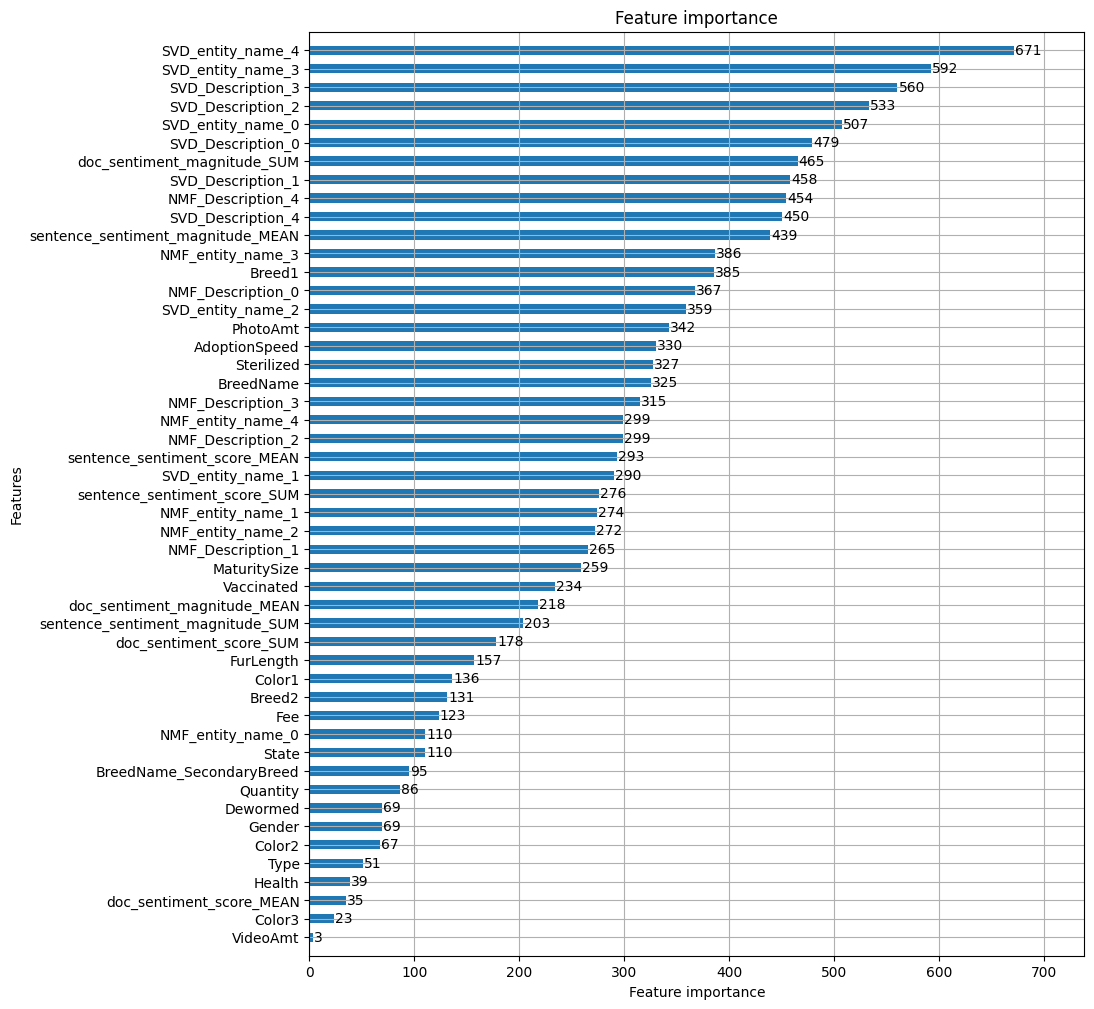

Total de datos en el dataset de entrenamiento: 11994
Datos utilizados en el entrenamiento actual: 11994
Porcentaje de datos utilizados: 100.00%


In [25]:
# Evaluar el modelo en el conjunto de prueba
y_pred = lgb_model.predict(X_test).argmax(axis=1)
kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f'Kappa: {kappa_score}')
print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_accuracy}')

# Mostrar la matriz de confusión
display(plot_confusion_matrix(y_test, y_pred))

# Información adicional del modelo
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
lgb.plot_importance(lgb_model, height=0.5, figsize=(10, 12))
plt.show()

# Tamaño total del dataset de entrenamiento
total_data = X_train.shape[0]
train_data = X_train.shape[0]
percentage_used = (train_data / total_data) * 100

print(f"Total de datos en el dataset de entrenamiento: {total_data}")
print(f"Datos utilizados en el entrenamiento actual: {train_data}")
print(f"Porcentaje de datos utilizados: {percentage_used:.2f}%")